# Master's Thesis Analysis

Predicting discharge times of patients??

#### Author: Derek Lee

## Load Requisite Libraries and authenticate to local Postgres database

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import time
import psutil
import numpy as np
import multiprocessing as mp

from sklearn.model_selection import train_test_split



In [2]:
# Check the number of cores and memory usage
num_cores = mp.cpu_count()
print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

This kernel has  8 cores and you can find the information regarding the memory usage: svmem(total=17179869184, available=7139704832, percent=58.4, used=9234681856, free=711114752, active=6423097344, inactive=6198931456, wired=2811584512)


In [3]:
%reload_ext sql
from sqlalchemy import create_engine

In [4]:
import json
json_file = open("secrets.json")
variables = json.load(json_file)
json_file.close()

import os
os.environ['POSTGRES_USERNAME'] = variables['POSTGRES_USERNAME']
os.environ['POSTGRES_PASSWORD'] = variables['POSTGRES_PASSWORD']
os.environ['POSTGRES_ADDRESS'] = variables['POSTGRES_ADDRESS']
os.environ['POSTGRES_PORT'] = variables['POSTGRES_PORT']
os.environ['POSTGRES_DBNAME'] = variables['POSTGRES_DBNAME']

In [5]:
# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=os.getenv('POSTGRES_USERNAME'),
                        password=os.getenv('POSTGRES_PASSWORD'),
                        ipaddress=os.getenv('POSTGRES_ADDRESS'),
                        port=os.getenv('POSTGRES_PORT'),
                        dbname=os.getenv('POSTGRES_DBNAME'))) 
# Create the connection 
engine = create_engine(postgres_str)

-------------------------------------

### Note: Large Dataset:
Running below will take about 5 minutes because it's a dataset with approx 20 million rows

Update: cleaned the data further in sql, reducine our dataset to 3328 rows for 785 unique patients and taking 14 seconds to upload. Seems like tons of duplicate rows, which we removed to get a dataset of 3300 rows ish and 785 unique patients

In [6]:
# Use "postgres -D /usr/local/var/postgres" if the postgres database ever is shut down incorrectly therefore you can't connect


from datetime import datetime 

start_time = datetime.now() 

import time

data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine)


# data = pd.read_sql('''SELECT * FROM public."thesis_data";''', con=engine, chunksize=1000000)


print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:07.809192


In [7]:
data.columns


Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code'],

`admittime` = time admitted to hospital  
`dischtime` = time discharged from hospital  
`edregtime` = time registered in ED  
`edouttime` = time discharge from ED    
`createtime` = time and date that the call out was initiated  
`updatetime` = last time at which the call out event was updated  
`acknowledgetime` = time at which the call out was first acknowledged  
`outcometime` = time at which the CALLOUT_OUTCOME occurred  
`intime` = provides the date and time the patient was transferred into the ICU  
`outtime` = provides the date and time the patient was transferred out of the ICU  
`los` = length of stay for the patient for the given ICU stay, which may include one or more ICU units. The length of stay is measured in fractional days.


Most variables are categorical, some being text while others are number codes. For the times, we can convert into cyclical time features https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/ so it becomes continuous.

In [8]:
data.shape

(3328, 60)

In [188]:
data[['subject_id','intime','createtime', 'updatetime', 'acknowledgetime', 'transfertime' , 'outtime', 'prev_service']].head(20)

,subject_id,intime,createtime,updatetime,acknowledgetime,transfertime,outtime,prev_service
0,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
1,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
2,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
3,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
4,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
5,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
6,160,2174-11-06 10:07:03,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-06 08:38:58,2174-11-07 22:37:53,None
7,197,2174-03-23 00:34:45,2174-03-23 15:46:47,2174-03-23 15:46:47,NaT,2174-03-22 19:48:19,2174-03-23 20:24:29,None
8,197,2174-03-23 00:34:45,2174-03-23 15:46:47,2174-03-23 15:46:47,NaT,2174-03-22 19:48:19,2174-03-23 20:24:29,None
9,262,2153-09-25 18:02:24,2153-09-27 12:58:24,2153-09-27 12:58:24,NaT,2153-09-25 18:02:24,2153-09-27 13:59:18,None


In [191]:
pd.set_option('display.max_columns', None)
data[data['subject_id']==160]

# difference between rows is the seq_num and the icd9_code



,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
0,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,1,0066,1 days 12:30:50,12.5
1,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,2,3606,1 days 12:30:50,12.5
2,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,3,3723,1 days 12:30:50,12.5
3,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,4,0045,1 days 12:30:50,12.5
4,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,5,0040,1 days 12:30:50,12.5
5,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672,2174-11-06 08:38:00,2174-11-08 16:35:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,None,WHITE,2174-11-06 08:19:00,2174-11-06 08:39:00,ST ELEVATION MI,0,1,7,None,17,CCU,17,CCU,0,0,Inactive,Discharged,17.0,Revised,2174-11-07 13:21:49,2174-11-07 18:18:26,NaT,2174-11-07 22:55:02,CCU,CCU,7,7,2174-11-06 10:07:03,2174-11-07 22:37:53,1.5214,ICU,99291,99291,None,Evaluation and management,Critical care services,None,2174-11-06 08:38:58,None,CMED,6,8856,1 days 12:30:50,12.5
6,F,2124-11-22,NaT,NaT,NaT,0,214,160,161672

In [200]:
data[data['acknowledgetime'].isna()==False].head(40)

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 19:56:38,19.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 19:56:38,19.9
16,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,1,527,2 days 21:40:10,21.7
17,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,1,527,2 days 21:40:10,21.7
18,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,2,5122,2 days 21:40:10,21.7
19,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary

In [195]:
data.admission_location.unique()

array(['EMERGENCY ROOM ADMIT', 'PHYS REFERRAL/NORMAL DELI',
       'TRANSFER FROM HOSP/EXTRAM', 'CLINIC REFERRAL/PREMATURE'],
      dtype=object)

In [196]:
data.discharge_location.unique()

array(['HOME', 'REHAB/DISTINCT PART HOSP', 'HOME HEALTH CARE',
       'DISCH-TRAN TO PSYCH HOSP', 'SNF', 'LEFT AGAINST MEDICAL ADVI',
       'SHORT TERM HOSPITAL', 'DISC-TRAN CANCER/CHLDRN H', 'DEAD/EXPIRED',
       'HOME WITH HOME IV PROVIDR', 'LONG TERM CARE HOSPITAL'],
      dtype=object)

In [194]:
data.description.unique()

array([None, 'VENT MGMT, 1ST DAY (INVASIVE)',
       'VENT MGMT;SUBSQ DAYS(INVASIVE)', 'VENT MGMT;SUBSQ DAYS(NIV)',
       'VENT MGMT,1ST DAY (NIV)'], dtype=object)

In [193]:
data.diagnosis.unique()

array(['ST ELEVATION MI',
       'EXPLORATORY LAPAROTOMY FOR SMALL BOWEL OBSTRUCTION',
       'HYPERTROPHIC CARDIOMYOPATHY\\ETHANOL SEPTAL ABLATION/SDA',
       'INFECTED RIGHT FOOT', 'METASTATIC PANCREATIC CA/SDA',
       'VENTRAL HERNIA/SDA',
       'CAD, MR\\CORONARY ARTERY BYPASS GRAFT;MITRAL VALVE REPLACEMENT/SDA',
       'CORONARY ARTERY DISEASE',
       'CORONARY ARTERY DISEASE;HYPERTENSION\\CATH',
       'ATRIAL SEPTAL DEFECT;PATENT FORAMEN OVALE\\MINIMALLY INVASIVE PATENT FORAMEN OVALE ',
       'PAROXYSMAL ATRIAL AFRIBILLATION\\MITRAL VALVE REPLACEMENT (FULL MAZE) /SDA',
       'SUBDURAL HEMORRHAGE', 'MR\\MITRAL VALVE REPLACEMENT /SDA',
       'MR\\MITRAL VALVE REPLACEMENT; ? CORONARY ARTERY BYPASS GRAFT ',
       'ATRIAL FIBRILLATION\\ATRIAL FIBRILLATION ABLATION',
       'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA',
       'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA',
       'ANTERIOR MEDIASTINAL MASS/SDA',
       'ASCENDING SINUS VENUS\\ REPA

#### Creating the target variable:

Our target variable is the time it takes from when a person is ready for discharge to when they are actually discharged. This needs to be engineered from our data.

In [803]:
# data['timediff'] = data['outtime']-data['intime']


data['timediff'] = data['outcometime']-data['acknowledgetime']

In [216]:
data[data['timediff'].isna()==False] # success!

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9
16,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,1,527,1 days 08:29:33,21.7
17,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,1,527,1 days 08:29:33,21.7
18,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,ICU,47130,47130,None,Surgery,Digestive system,None,2190-01-05 00:37:59,None,SURG,2,5122,1 days 08:29:33,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,F,2055-07-17,2144-01-23,NaT,2144-01-23,1,58917,99814,186518,2142-02-16 16:33:00,2142-02-21 16:38:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,SNF,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaT,NaT,TRANSIENT ISCHEMIC ATTACK,

**Creating other variables**

In [453]:
# to do: convert times into intervals in hours (admittime to dischtime, edregtime to edouttime, intime to outtime)
# new columns and then dummify: month of death (see deathtime code when graphed)
# new columns: age when they arrived in hospital

data['deathmonth'] = data['dod'].dt.month
data['admit2disch_hours'] = (data['dischtime'].sub(data['admittime']).dt.seconds/60/60).round(1)
data['edreg2edout_hours'] = (data['edouttime'].sub(data['edregtime']).dt.seconds/60/60).round(1)
data['in2out_hours'] = (data['outtime'].sub(data['intime']).dt.seconds/60/60).round(1)

data['age'] = data['admittime'].sub(data['dob']).astype('timedelta64[Y]').astype('int')
 




In [443]:
data[data['subject_id']==286]

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours,deathmonth,admit2disch_hours,edreg2edout_hours,in2out_hours
14,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.831,ICU,99253,99253,None,Evaluation and management,Consultations,None,2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9,4.0,19.9,NaN,19.9
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.831,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9,4.0,19.9,NaN,19.9


In [804]:
timediff_noNA = data[data['timediff'].isna()==False]

timediff_noNA.drop_duplicates(subset=['subject_id','diagnosis'], keep='last')

,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,submit_careunit,curr_wardid,curr_careunit,callout_wardid,callout_service,request_cdiff,request_mrsa,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,costcenter,cpt_cd,cpt_number,cpt_suffix,sectionheader,subsectionheader,description,transfertime,prev_service,curr_service,seq_num,icd9_code,timediff,timediff_hours,deathmonth,admit2disch_hours,edreg2edout_hours,in2out_hours,age
15,F,2090-12-25,2176-04-27,NaT,2176-04-27,1,363,286,135917,2176-04-10 20:45:00,2176-04-12 16:41:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,None,CATHOLIC,WIDOWED,WHITE,NaT,NaT,INFECTED RIGHT FOOT,0,0,57,SICU,57,SICU,1,VSURG,0,0,Inactive,Discharged,0.0,Acknowledged,2176-04-11 09:57:03,2176-04-11 09:57:03,2176-04-11 12:00:30,2176-04-12 16:55:02,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,1.8310,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2176-04-10 20:46:09,None,VSURG,1,8411,1 days 04:54:32,19.9,4.0,19.9,NaN,19.9,85
25,F,2132-06-06,NaT,NaT,NaT,0,414,325,155989,2190-01-05 07:15:00,2190-01-16 13:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,NaT,NaT,METASTATIC PANCREATIC CA/SDA,0,1,57,None,54,SICU,54,SURG,0,0,Inactive,Discharged,54.0,Acknowledged,2190-01-07 09:41:25,2190-01-07 09:41:25,2190-01-07 09:55:29,2190-01-08 18:25:02,SICU,SICU,57,57,2190-01-05 20:28:18,2190-01-08 18:08:28,2.9029,Resp,94003,94003,None,Medicine,Pulmonary,VENT MGMT;SUBSQ DAYS(INVASIVE),2190-01-05 00:37:59,None,SURG,5,9907,1 days 08:29:33,21.7,NaN,6.4,NaN,21.7,57
27,F,2091-05-22,2171-11-14,NaT,2171-11-14,1,543,423,128697,2171-03-29 07:15:00,2171-04-03 14:54:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,NaT,NaT,VENTRAL HERNIA/SDA,0,1,33,None,40,SICU,40,SURG,0,0,Inactive,Discharged,40.0,Acknowledged,2171-03-31 09:11:40,2171-03-31 09:11:40,2171-03-31 10:22:30,2171-03-31 13:25:03,SICU,SICU,33,33,2171-03-30 12:48:57,2171-03-31 13:12:22,1.0163,ICU,99254,99254,None,Evaluation and management,Consultations,None,2171-03-29 02:49:36,None,SURG,2,5794,0 days 03:02:33,0.4,11.0,7.6,NaN,0.4,79
37,M,2088-11-09,2160-02-03,NaT,2160-02-03,1,567,443,145041,2159-09-24 11:30:00,2159-10-05 14:45:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Medicare,None,NOT SPECIFIED,SINGLE,WHITE,NaT,NaT,"CAD, MR\CORONARY ARTERY BYPASS GRAFT;MITRAL VA...",0,1,14,None,55,CSRU,55,CSURG,0,0,Inactive,Discharged,55.0,Acknowledged,2159-09-27 12:39:09,2159-09-27 12:39:09,2159-09-27 12:56:32,2159-09-28 09:40:07,CSRU,CSRU,14,14,2159-09-25 07:04:39,2159-09-28 09:16:44,3.0917,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2159-09-24 00:53:08,None,CSURG,5,9904,0 days 20:43:35,2.2,2.0,3.2,NaN,2.2,70
41,F,2129-12-24,NaT,NaT,NaT,0,611,485,116665,2195-02-18 18:25:00,2195-02-25 16:20:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Private,None,PROTESTANT QUAKER,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE,0,1,12,None,55,CSRU,55,CSURG,0,0,Inactive,Discharged,55.0,Acknowledged,2195-02-21 09:43:13,2195-02-21 09:43:13,2195-02-21 10:39:21,2195-02-22 17:10:02,CSRU,CSRU,12,12,2195-02-19 15:08:52,2195-02-22 16:59:50,3.0771,Resp,94002,94002,None,Medicine,Pulmonary,"VENT MGMT, 1ST DAY (INVASIVE)",2195-02-18 18:27:32,None,CSURG,4,9904,1 days 06:30:41,1.8,NaN,21.9,NaN,1.8,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [455]:
min(timediff_noNA.timediff)
max(timediff_noNA.timediff)
(timediff_noNA.timediff).mean()

Timedelta('0 days 07:06:50.719309')

-----------------------------------------------------------------------

## Exploratory Data Analysis

In [805]:
timediff_noNA.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

##### Initial logic checks:

While we deduped the initial dataset, we still have lots to do to inspect and clean our data.  

1) Look to see if data makes sense. Check if there are any patients where their date of death (dod) is before date of birth (dob), is edregtime before edouttime?

2) If there are any of the times that are out of order (besides date of birth), we can flag those as administrative errors  


In [457]:
# data.gender.unique()

from datetime import datetime, timedelta 
# truth = ((data.dod.dt.date-data.dob.dt.date)<timedelta(0))
# truth = ((data.edouttime.dt.date-data.edregtime.dt.date)<timedelta(0))
# truth = ((data.updatetime.dt.date-data.createtime.dt.date)<timedelta(0))
truth = ((timediff_noNA.outtime.dt.date-data.intime.dt.date)<timedelta(0))
truth.unique()



array([False])

It appears that we don't have any errors with the order of times in our data. If we did, we would see some negative values in the subtraction of the two dates and therefore the array would have `True` values.  

We do have issues with the years in the `dob` and `dod` variables corresponding to date of birth and date of death. We may have to discard these as there's no better wage to ascertain age.

In [458]:
sorted(timediff_noNA['dob'].unique())

[numpy.datetime64('1804-03-11T00:00:00.000000000'),
 numpy.datetime64('1813-10-20T00:00:00.000000000'),
 numpy.datetime64('1816-03-20T00:00:00.000000000'),
 numpy.datetime64('1846-08-05T00:00:00.000000000'),
 numpy.datetime64('1850-02-19T00:00:00.000000000'),
 numpy.datetime64('1862-02-03T00:00:00.000000000'),
 numpy.datetime64('1865-03-21T00:00:00.000000000'),
 numpy.datetime64('1867-07-26T00:00:00.000000000'),
 numpy.datetime64('1868-06-22T00:00:00.000000000'),
 numpy.datetime64('1868-07-18T00:00:00.000000000'),
 numpy.datetime64('1870-11-10T00:00:00.000000000'),
 numpy.datetime64('1870-12-31T00:00:00.000000000'),
 numpy.datetime64('1874-10-20T00:00:00.000000000'),
 numpy.datetime64('1878-05-07T00:00:00.000000000'),
 numpy.datetime64('1879-12-20T00:00:00.000000000'),
 numpy.datetime64('1890-02-13T00:00:00.000000000'),
 numpy.datetime64('1900-11-14T00:00:00.000000000'),
 numpy.datetime64('2014-01-01T00:00:00.000000000'),
 numpy.datetime64('2016-11-18T00:00:00.000000000'),
 numpy.datet

##### Check for missing values

In [459]:
# timediff_noNA['dod'].isna().sum() # 2417 people did not die within 90 days post discharge
# timediff_noNA['dod_hosp'].isna().sum() # 2739 people did not die in hospital
# timediff_noNA['dod_ssn'].isna().sum() # 2487 did not die according to social security records
# timediff_noNA['language'].isna().sum() # 919 unknown language
# timediff_noNA['marital_status'].isna().sum() # 120 unknown marital status
# timediff_noNA['edregtime'].isna().sum() # 2231 unknown edregtime, edouttime - likely didn't visit ED
# timediff_noNA['submit_careunit'].isna().sum() # 2846 was not from ICU
# timediff_noNA['discharge_wardid'].isna().sum() # 66 unknown wards to which the patient was discharged.
# timediff_noNA['acknowledgetime'].isna().sum() # 314 did not record acknowledgetime
# timediff_noNA['cpt_suffix'].isna().sum() # 3014 unknown Text element of the Current Procedural Terminology (CPT)
# timediff_noNA['description'].isna().sum()# 1333 missing description of CPT
# timediff_noNA['prev_service'].isna().sum() # 2996 missing previous service type


`expire_flag`, `deathtime` will of course have some missing since it's indicating who died or not

In [746]:
timediff_noNA['marital_status'] = timediff_noNA['marital_status'].replace([None,'UNKNOWN (DEFAULT)'], 'UNKNOWN_MARITAL')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['UNKNOWN/NOT SPECIFIED',
                                                                           'PATIENT DECLINED TO ANSWER',
                                                                          'UNABLE TO OBTAIN'], 'UNKNOWN_ETHNICITY')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['ASIAN - CHINESE'], 'ASIAN')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['HISPANIC OR LATINO',
                                                                           'HISPANIC/LATINO - GUATEMALAN',
                                                                           'HISPANIC/LATINO - PUERTO RICAN',
                                                                           'HISPANIC/LATINO - DOMINICAN',
                                                                          'WHITE - BRAZILIAN'], 'HISPANIC_LATINO')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['BLACK/AFRICAN AMERICAN',
                                                                          'BLACK/AFRICAN',
                                                                           'BLACK/CAPE VERDEAN'], 'BLACK')

timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['MULTI RACE ETHNICITY'],'MIXED_ETHNICITY')
timediff_noNA['ethnicity'] = timediff_noNA['ethnicity'].replace(['OTHER'],'OTHER_ETHNICITY')

timediff_noNA['language'] = timediff_noNA['language'].replace([None],'UNKNOWN')

timediff_noNA['description'] = timediff_noNA['description'].replace([None],'NOT APPLICABLE')





/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [780]:
# somehow the replace doesn't work here? Refresh dataset?

timediff_noNA.diagnosis_categories.unique()

array(['INFECTIONS', 'METASTATIC PANCREATIC CA/SDA', 'VENTRAL HERNIA/SDA',
       'CAD, MR\\CORONARY ARTERY BYPASS GRAFT;MITRAL VALVE REPLACEMENT/SDA',
       'CARDIOVASCULAR',
       'ATRIAL SEPTAL DEFECT;PATENT FORAMEN OVALE\\MINIMALLY INVASIVE PATENT FORAMEN OVALE ',
       'PAROXYSMAL ATRIAL AFRIBILLATION\\MITRAL VALVE REPLACEMENT (FULL MAZE) /SDA',
       'MR\\MITRAL VALVE REPLACEMENT /SDA',
       'MR\\MITRAL VALVE REPLACEMENT; ? CORONARY ARTERY BYPASS GRAFT ',
       'ATRIAL FIBRILLATION\\ATRIAL FIBRILLATION ABLATION',
       'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA',
       'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA',
       'ASCENDING SINUS VENUS\\ REPAIR ANOMALY PULMONARY VEIN; ASCENDING AORTIC VALVE REPLACEMENT/SDA',
       'GENERAL TRAUMA', 'SCOLIOSIS/SDA', 'NEUROLOGICAL',
       'LUMBAR STENOSIS/SDA', 'BRAIN TUMOR/SDA',
       'MITRAL REGURGITATION\\MINIMALLY INVASIVE MITRAL VALVE REPLACEMENT /SDA',
       'ABSCESS OF GALLSTONES/SDA',
   

In [774]:
timediff_noNA['diagnosis_categories'] = timediff_noNA.loc[:,'diagnosis']

/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [779]:
timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['ABDOMINAL ABSCESS',
                                                                           'ABDOMINAL AORTIC ANEURYSM',
                                                                           'ABDOMINAL AORTIC ANEURYSM;',
                                                                           'ABDOMINAL AORTIC ANURISM REPAIR',
                                                                          'ABDOMINAL INFECTION',
                                                                           'ABDOMINAL PAIN',
                                                                           'ACUTE CHOLECYSTITIS',
                                                                           'BOWEL OBSTRUCTION',
                                                                           'BOWEL OBSTRUCTION;FAILURE TO THRIVE',
                                                                           'CHOLANGITIS','CHOLANGITIS ABSCESS',
                                                                            'CHOLECYSTITIS','ESOPHAGEAL FOREIGN BODY',
                                                                            'FOREIGN BODY IN ESOPHAGUS',
                                                                                      'FOREIGN BODY IN STOMACH',
                                                                                      'FOREIGN BODY INGESTION',
                                                                                      'GASTROINTESTINAL BLEED',
                                                                                      'GI BLEED',
                                                                                      'HEMATURIA;BLADDER BLEED',
                                                                                      'HEMOPERITONEUM',
                                                                                      'HEMOPTYSIS',
                                                                                      'ISCHEMIC BOWEL; HERNIA',
                                                                            'LIVER LACERATION',
                                                                            'LOWER GASTROINTESTINAL BLEED',
                                                                            'LOWER GI BLEED',
                                                                            'NEED GI SCOPE',
                                                                            'PANCREATIC ABCESS',
                                                                            'PANCREATITIS',
                                                                            'RECTAL BLEEDING',
                                                                            'RUPTURED DUODENAL ULCER',
                                                                            'SMALL BOWEL OBSTRUCTION',
                                                                            'SPLEENIC LACERATION',
                                                                            'UPPER GASTROINTESTINAL BLEED',
                                                                            'UPPER GI BLEED',
                                                                            'UPPER GI BLEED;TELEMETRY'],'GI')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['ACUTE CORONARY SYNDROME',
                                                                           'ACUTE CORONARY SYNDROME\\CATH',
                                                                           'ACUTE MYOCARDIAL INFARCTION',
                                                                           'ACUTE SUBDORAL HEMATOMA',
                                                                           'ACUTE SUBDURAL HEMATOMA',
                                                                          'ALCOHOL WITHDRAWL;CARDIOMYOPATHY;VENTRICULAR TACHYCARDIA',
                                                                           'ANGINA;+ETT','AORTIC DISSECTION',
                                                                           'AORTIC INSUFFICIENCY','AORTIC STENISIS',
                                                                           'AORTIC STENOSIS',
                                                                           'AORTIC STENOSIS;CORONARY ARTERY DISEASE\\AORTIC ROOT REPLACEMENT REPAIR;? ASCENDING AORTIC REPLACEMENT',
                                                                           'AORTIC VALVE ENDOCARDITIS;AORTIC INSUFFICIENCY\\CATH',
                                                                           'ASCENDING THORASIC ANEURYSM',
                                                                           'ATRIAL TACHYCARDIA','BRADYCARDIA',
                                                                           'BRADYCARDIA;DIZZINESS',
                                                                           'CAD,AORTIC VALVE DISEASE',
                                                                           'CARDIOMYOPATHY',
                                                                           'CAROTID STENOSIS',
                                                                           'CAROTID STENOSIS LEFT',
                                                                           'CAROTID STENOSIS\\CAROTID ANGIOGRAPHY',
                                                                           'CHEST PAIN',
                                                                           'CHEST PAIN/CATH',
                                                                           'CHEST PAIN;ABNORMAL ECHO;ADNORMAL EKG\\CARDIAC CATH',
                                                                           'CHEST PAIN;ANGINA PECTORIS\\CARDIAC CATH',
                                                                           'CHEST PAIN;NON-Q WAVE MI',
                                                                           'CHEST PAIN;RULE OUT CORONARY ARTERY DISEASE;ASPIRIN ALLERGY\\LEFT HEART CATHETERIZATION',
                                                                           'CHEST PAIN;UNSTABLE ANGINA',
                                                                           'CHEST PAIN\\ASPIRIN DESENSITIZATION;CATH',
                                                                           'CHEST PAIN\\CARDIAC CATH',
                                                                           'CHEST PAIN\\CARDIAC CATHETERIZATION',
                                                                           'CHEST PAIN\\CATH',
                                                                            'CLAUDICATION\\BILATERAL ANGIOGRAM WITH RUN-OFFS',
                                                                            'COMPLETE HEART BLOCK',
                                                                            'CONGESTIVE HEART FAILURE',
                                                                            'CONGESTIVE HEART FAILURE/MITRAL REGURGITATION',
                                                                            'CONGESTIVE HEART FAILURE;CORONARY ARTERY DISEASE',
                                                                            'CONGESTIVE HEART FAILURE;DYSPNEA\\CATH',
                                                                            'CONGESTIVE HEART FAILURE;TELEMETRY;CORONARY ARTERY DISEASE;DIABETES MELLITUS',
                                                                            'CONGESTIVE HEART FAILURE\\CATH',
                                                                            'CORONARY ARTERY DISEASE',
                                                                            'CORONARY ARTERY DISEASE/CATH',
                                                                            'CORONARY ARTERY DISEASE;+ETT\\CATH',
                                                                            'CORONARY ARTERY DISEASE;ANGINA\\CATH',
                                                                            'CORONARY ARTERY DISEASE;AORTIC STENOSIS',
                                                                            'CORONARY ARTERY DISEASE;CHEST PAIN',
                                                                            'CORONARY ARTERY DISEASE;DYSPNEA;COPD',
                                                                            'CORONARY ARTERY DISEASE;HYPERTENSION\\CATH',
                                                                            'CORONARY ARTERY DISEASE;PROGRESSIVE CHEST PAIN\\CATH',
                                                                            'CORONARY ARTERY DISEASE;UNSTABLE ANGINA',
                                                                            'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT',
                                                                            'CRITICAL AS , LEFT MAIN',
                                                                            'END ST ELEVATED MYOCARDIAL INFARCTION',
                                                                            'FOOT NUMBNESS;CLAUDICATION\\RIGHT LEG ANGIOGRAM',
                                                                            'HEART BLOCK,NON STE MI',
                                                                            'HYPOTENSION','ISCHEMIC FOOT',
                                                                            'LEFT ANTERIOR DESCENDING ARTERY PERFERATION',
                                                                            'LEFT ATRIAL TUMOR',
                                                                            'LEFT CELEBRAL STENOSIS/SDA',
                                                                            'MALFUCTION ICD','MITRAL REGURGITATION',
                                                                            'MITRAL REGURGITATION;CHF',
                                                                            'MITRAL VALVE DISEASE',
                                                                            'MYOCARDIAL INFARCTION\\CATH',
                                                                            'NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION',
                                                                            'NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'PERF APPENDIX',
                                                                            'PERICARDIAL EFFUSION',
                                                                            'PERICARDIAL EFFUSION WITH TAMPONADE\\PERICARDIOCENTESIS',
                                                                            'PERICARDIAL EFFUSION\\PERICARDIAL TAP/SDA',
                                                                            'PNA/AFIB',
                                                                            'POLYMORPHIC VENTRICULAR TACHYCARDIA\\CARDIAC CATH',
                                                                            'PULSELESS LEFT FOOT',
                                                                            'RECURRENT VENTRICULAR TACHYCARDIA;STATUS POST IMPLANTABLE CARDIOVERTER DEFIBRILLATOR FIRING\\VENTRICULAR TACHYCARDIA ABLATION',
                                                                            'RUPTURED AORTIC PLAQUE',
                                                                            'S/P ARREST',
                                                                            'S/P CARDIAC ARREST',
                                                                            'S/P VFIB ARREST',
                                                                            'SDH/SAH',
                                                                            'SPONTANEOUS SAH',
                                                                            'ST ELEVATED MYOCARDIAL INFARCTION',
                                                                            'ST ELEVATED MYOCARDIAL INFARCTION\\CARDIAC CATHETERIZATION',
                                                                            'ST ELEVATION MI\\CATH',
                                                                            'ST ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'ST SEGMENT MYOCARDIAL INFARCTION\\CATH',
                                                                            'ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'STEMI',
                                                                            'STEMI\\CARDIAC CATH',
                                                                            'STEMYOCARDIAL INFARCTION',
                                                                            'STROKE/TIA',
                                                                            'SUBARACHNOID HEMATOMA',
                                                                            'SUBARACHNOID HEMORRHAGE',
                                                                            'SUBARACHNOID HEMORRHAGE;SDH;TELEMETRY',
                                                                            'SUBARRACHNOID HEMMORAGE',
                                                                            'SUBDURAL',
                                                                            'SUBDURAL HEMATOMA',
                                                                            'SUBDURAL HEMATOMA;TELEMETRY',
                                                                            'SUBDURAL HEMORRHAGE',
                                                                            'SUBURAL HEMATOMA;TELEMETRY',
                                                                            'SYMPTOMATIC BRADYCARDIA',
                                                                            'SYNCOPE;TELEMETRY',
                                                                            'THORACIC AORTIC ANEURYSM',
                                                                            'TRANSIENT ISCHEMIC ATTACK',
                                                                            'UNSTABLE ANGINA',
                                                                            'VENTRICULAR SEPTAL D EFFECT'],'CARDIOVASCULAR')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['ALTERED MENTAL STATUS',
                                                                           'ALTERED MENTAL STATUS;TELEMETRY',
                                                                           'BRAIN MASS',
                                                                           'BRAIN TUMOR',
                                                                            'EPIDURAL BLEED',
                                                                            'HYDROCEPHALUS','ICH',
                                                                            'INTRACEREBRAL HEMORRHAGE',
                                                                            'INTRACRANIAL BLEED',
                                                                            'INTRACRANIAL HEMORRHAGE',
                                                                            'INTRACRANIAL HEMORRHAGE;TELEMETRY',
                                                                            'INTRACRANIAL MASS',
                                                                            'INTRAPARENCHYMAL BLEED;TELEMETRY',
                                                                            'INTRAPARENCHYMAL HEMORRHAGE;TELEMETRY',
                                                                            'SEIZURE',
                                                                            'SEIZURE-HYDROCEPHALUS',
                                                                            'SEIZURE;SUBDURAL HEMORRHAGE',
                                                                            'SPIANAL METASTASES',
                                                                            'TRAUMA-HEAD INJURY',
                                                                            'TRAUMATIC SUBARACHNOID HEMORRHAGE'],'NEUROLOGICAL')


timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['AIRWAY OBSTRUCTION',
                                                                                      'HEMOTHORAX',
                                                                                      'HYPOXIA',
                                                                                      'MEDIASTINAL AIR',
                                                                                      'PNEUMONIA',
                                                                                      'PULMONARY EDEMA',
                                                                                      'PULMONARY EMBOLIS',
                                                                                      'RUPTURED DIAPHRAM',
                                                                                      'TRACHEOBRONCHEAL MALACIA'],'RESPIRATORY')


timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['BLUNT TRAUMA',
                                                                           'BOWEL PERFORATION',
                                                                            'CEREBRAL EDEMA',
                                                                           'CEREBROVASCULAR ACCIDENT',
                                                                           'CHEST STAB WOUNDS',
                                                                            'GUN SHOT WOUND',
                                                                            'GUN SHOT WOUND TO HEAD',
                                                                            'HEAD BLEED',
                                                                            'HEAD INJURY',
                                                                            'HEAD MAS',
                                                                            'HEAD MASS',
                                                                            'HEAD TRAUM',
                                                                            'HEAD TRAUMA;ETOH',
                                                                            'MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES',
                                                                            'MOTOR VEHICLE ACCIDENT\\INJURIES',
                                                                            'MULTIPLE STAB WOUNDS',
                                                                            'MULTIPLE TRAUMA',
                                                                            'NECK HEMATOMA',
                                                                            'ETOH INTOXICATION',
                                                                            'ETOH INTOXICATION;INTUBATED',
                                                                            'ETOH WITHDRAWAL',
                                                                            'POLYSUBSTANCE OVERDOSE',
                                                                            'S/P FALL',
                                                                            'S/P FALL; SPINE FX',
                                                                            'S/P FALL;FACIAL FRACTURE',
                                                                            'S/P GUN SHOT WOUND',
                                                                            'S/P MOTOR VEHICLE ACCIDEMT',
                                                                            'S/P MOTOR VEHICLE ACCIDENT',
                                                                            'S/P PEDESTRIAN STRUCK:INTRACRANIAL HEMORRHAGE',
                                                                            'S/P STAB WOUND',
                                                                            'S/P STAB WOUNDS',
                                                                            'STAB',
                                                                            'STAB WOUND',
                                                                            'STAB WOUND TO CHEST',
                                                                            'STAB WOUND TO NECK',
                                                                            'STAB WOUND TO THROAT',
                                                                            'STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES'],'GENERAL TRAUMA')

timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['CELLULITIS',
                                                                                     'INFECTED RIGHT FOOT',
                                                                                     'SEPSIS',
                                                                                    'SEPSIS/CELLULITIS'],'INFECTIONS')


timediff_noNA['diagnosis_categories'] = timediff_noNA['diagnosis_categories'].replace(['BLADDER RUPTURE',
                                                                                      'BLADDER PERFORATION',
                                                                                      'END STAGE LIVER DISEASE',
                                                                                      'FEBRILE;HYPOTENSIVE',
                                                                                      'FEVER',
                                                                                      'HEADACHE',
                                                                                      'OVERDOSE;TELEMETRY',
                                                                                      'PELVIC FRACTURE',
                                                                                      'PRESYNCOPE',
                                                                                      'TONSILLECTOMY BLEED',
                                                                                      'WEAKNESS'],'OTHER_DIAGNOSIS')




/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

##### Visualizing distributions of our data

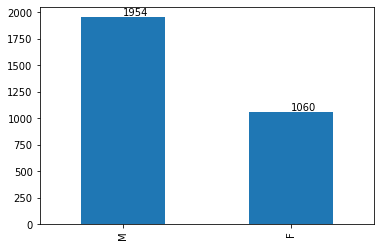

In [747]:
from scipy import stats
import matplotlib.pylab as plt

%matplotlib inline

(timediff_noNA.gender).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.gender.value_counts()):
    plt.text(index, value+15, str(value))





(array([  46.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  582.,
        2386.]),
 array([-285. , -247.7, -210.4, -173.1, -135.8,  -98.5,  -61.2,  -23.9,
          13.4,   50.7,   88. ]),
 <a list of 10 Patch objects>)

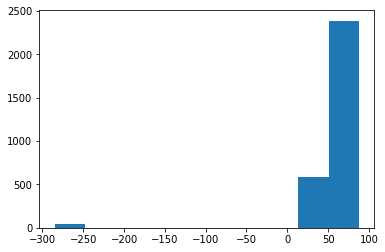

In [748]:
plt.hist(timediff_noNA.age) # check the weird values are just NA's in age

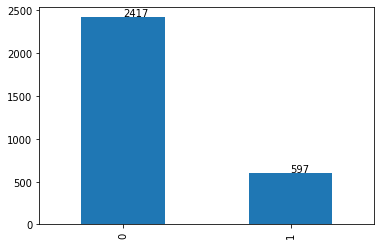

In [749]:
(timediff_noNA.expire_flag).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.expire_flag.value_counts()):
    plt.text(index, value+15, str(value))

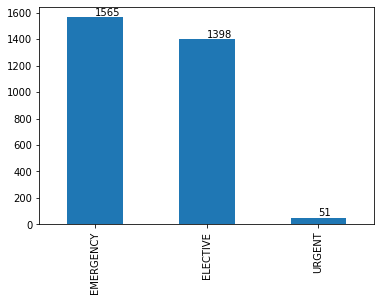

In [750]:
(timediff_noNA.admission_type).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.admission_type.value_counts()):
    plt.text(index, value+15, str(value))



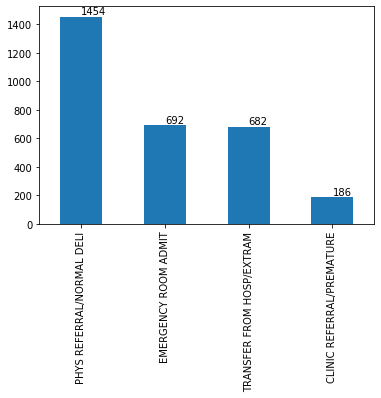

In [751]:
(timediff_noNA.admission_location).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.admission_location.value_counts()):
    plt.text(index, value+15, str(value))

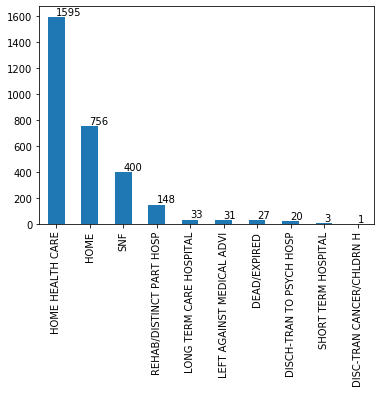

In [752]:
(timediff_noNA.discharge_location).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.discharge_location.value_counts()):
    plt.text(index, value+15, str(value))

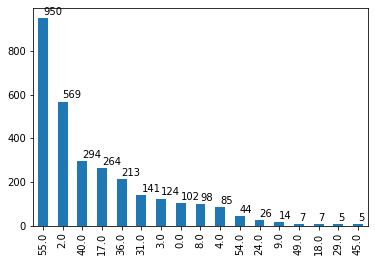

In [827]:
(timediff_noNA.discharge_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.discharge_wardid.value_counts()):
    plt.text(index, value+15, str(value))

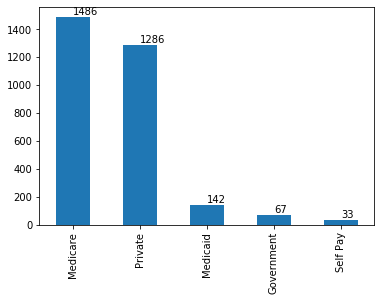

In [753]:
(timediff_noNA.insurance).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.insurance.value_counts()):
    plt.text(index, value+15, str(value))

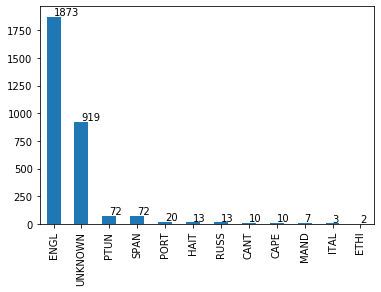

In [754]:
(timediff_noNA.language).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.language.value_counts()):
    plt.text(index, value+15, str(value))

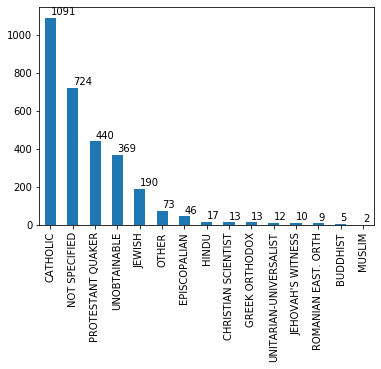

In [755]:
(timediff_noNA.religion).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.religion.value_counts()):
    plt.text(index, value+15, str(value))

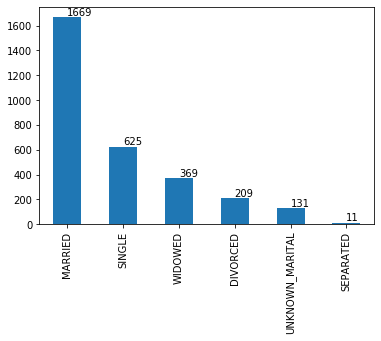

In [756]:
(timediff_noNA.marital_status).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.marital_status.value_counts()):
    plt.text(index, value+15, str(value))

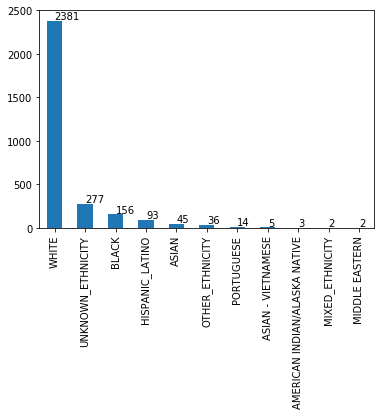

In [760]:
(timediff_noNA.ethnicity).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.ethnicity.value_counts()):
    plt.text(index, value+15, str(value))

In [784]:
# sorted((timediff_noNA.diagnosis_categories))

[' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 ' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 'AAA\\AORTIC VALVE REPLACEMENT;ASCENDING AORTIC  REPLACEMENT;AORTIC ARCH REPLACEMENT;DHCA/SDA',
 'AAA\\AORTIC VALVE REPLACEMENT;ASCENDING AORTIC  REPLACEMENT;AORTIC ARCH REPLACEMENT;DHCA/SDA',
 'AAA\\AORTIC VALVE REPLACEMENT;ASCENDING AORTIC  REPLACEMENT;AORTIC ARCH REPLACEMENT;DHCA/SDA',
 'AAA\\AORTIC VALVE REPLACEMENT;ASCENDING AORTIC  REPLACEMENT;AORTIC ARCH REPLACEMENT;DHCA/SDA',
 'ABDOMINAL AORTIC ANEURYSM/SDA',
 'ABDOMINAL AORTIC ANEURYSM/SDA',
 'ABDOMINAL AORT

In [787]:
[val for val in sorted(timediff_noNA.diagnosis_categories.unique())]



[' PERFORATED DIVERTICULITIS STATUS/POST HARTMANN PROCEDURE/SDA',
 'AAA\\AORTIC VALVE REPLACEMENT;ASCENDING AORTIC  REPLACEMENT;AORTIC ARCH REPLACEMENT;DHCA/SDA',
 'ABDOMINAL AORTIC ANEURYSM/SDA',
 'ABSCESS OF GALLSTONES/SDA',
 'ACENDING AORTIC ANEYRYS\\BENTAL PROCEDURE /SDA',
 'ACOUSTIC NEUROMA LEFT EAR/SDA',
 'ACOUSTIC NEUROMA, LEFT EAR/SDA',
 'ACUTE CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT ',
 'ADENOCARCINOMA STOMACH/SDA',
 'ADRENAL MASS/SDA',
 'ANEURYSM/SDA',
 'ANTERIOR COMMUNICATING ANEURYSM/SDA',
 'AORTIC INSUFFICIENCY & ENLARGEMENT\\AORTIC VALVE REPLACEMENT /SDA',
 'AORTIC INSUFFICIENCY\\AORTIC AND MITRAL VALVE REPLACEMENT /SDA',
 'AORTIC INSUFFICIENCY\\AORTIC VALVE REPLACEMENT /SDA',
 'AORTIC INSUFFICIENCY\\BENTAL PROCEDURE; REPLACING ASCENDING & HEMI-ARCH AORTA; ? CABG W/DEEP HYPOTHERMIC ARREST/SDA',
 'AORTIC STENOSIS; CAD\\AORTIC VALVE REPLACEMENT; POSSIBLE CORONARY ARTERY BYPASS GRAFT & MAZE',
 'AORTIC STENOSIS;MR\\ AORTIC AND MITRAL VALVE REPLACEMENT',
 'AORTIC

In [785]:
# for d in timediff_noNA.diagnosis_categories:
#     print(d,": " ,timediff_noNA.diagnosis_categories[d].count())
(timediff_noNA.diagnosis_categories).value_counts()


CARDIOVASCULAR                                                1040
GENERAL TRAUMA                                                 224
GI                                                             190
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA      157
NEUROLOGICAL                                                   113
                                                              ... 
SEPTAL DEFECT\PATENT FORAMEN OVALE MINIMALLY INVASIVE /SDA       1
CONTRICTIVE PERICARDITIS\PERICARDIAL STRIPPING/SDA               1
EPILEPSY/SDA                                                     1
ACOUSTIC NEUROMA LEFT EAR/SDA                                    1
INCISIONAL HERNIA/SDA                                            1
Name: diagnosis_categories, Length: 212, dtype: int64

In [788]:
# (timediff_noNA.diagnosis_categories).value_counts().plot(kind='bar')
# for index, value in enumerate(timediff_noNA.diagnosis_categories.value_counts()):
#     plt.text(index, value+15, str(value))

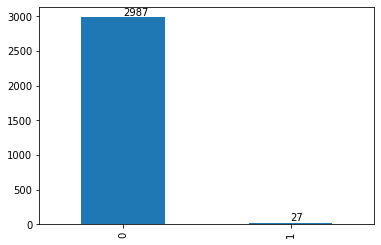

In [797]:
(timediff_noNA.hospital_expire_flag).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.hospital_expire_flag.value_counts()):
    plt.text(index, value+25, str(value))

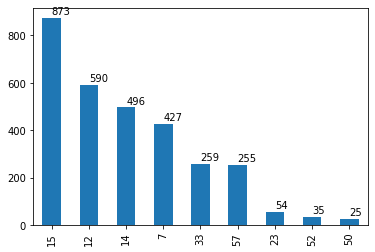

In [829]:
(timediff_noNA.first_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.first_wardid.value_counts()):
    plt.text(index, value+15, str(value))

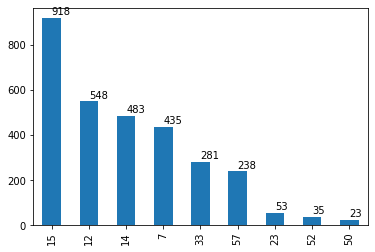

In [830]:
(timediff_noNA.last_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.last_wardid.value_counts()):
    plt.text(index, value+15, str(value))

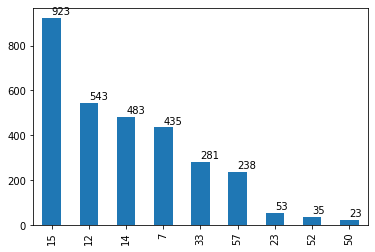

In [790]:
(timediff_noNA.submit_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.submit_wardid.value_counts()):
    plt.text(index, value+15, str(value))

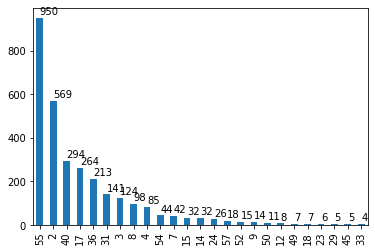

In [798]:
(timediff_noNA.curr_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.curr_wardid.value_counts()):
    plt.text(index, value+15, str(value))

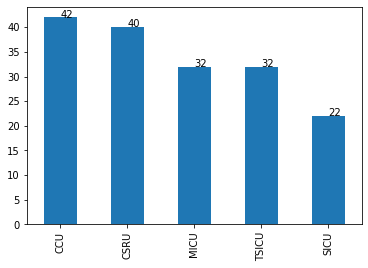

In [812]:
(timediff_noNA.submit_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.submit_careunit.value_counts()):
    plt.text(index, value, str(value))

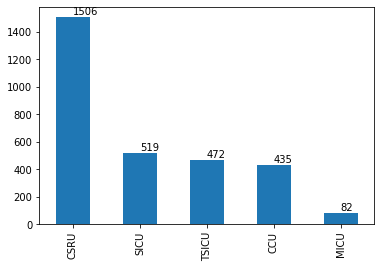

In [799]:
(timediff_noNA.curr_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.curr_careunit.value_counts()):
    plt.text(index, value+15, str(value))

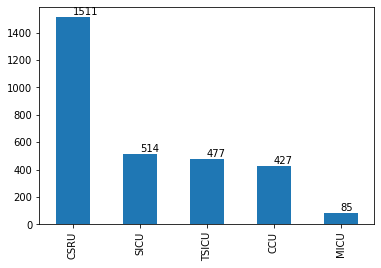

In [811]:
(timediff_noNA.first_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.first_careunit.value_counts()):
    plt.text(index, value+15, str(value))

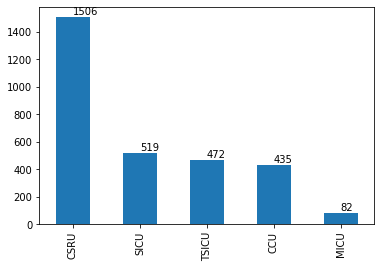

In [828]:
(timediff_noNA.last_careunit).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.last_careunit.value_counts()):
    plt.text(index, value+15, str(value))

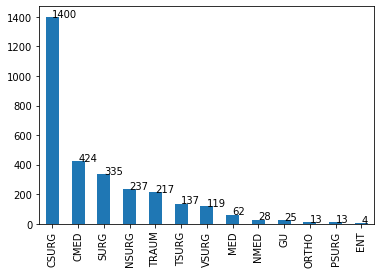

In [843]:
(timediff_noNA.curr_service).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.curr_service.value_counts()):
    plt.text(index, value, str(value))

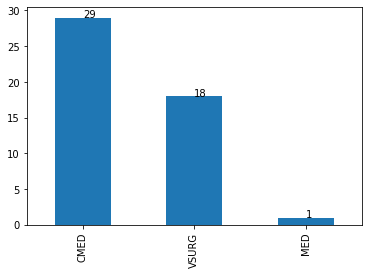

In [844]:
(timediff_noNA.prev_service).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.prev_service.value_counts()):
    plt.text(index, value, str(value))

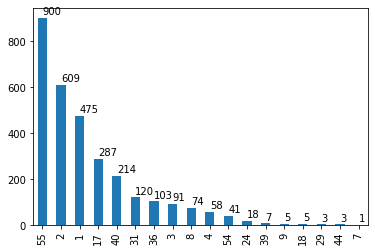

In [813]:
(timediff_noNA.callout_wardid).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.callout_wardid.value_counts()):
    plt.text(index, value+15, str(value))

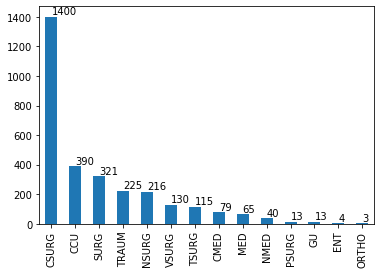

In [814]:
(timediff_noNA.callout_service).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.callout_service.value_counts()):
    plt.text(index, value+15, str(value))

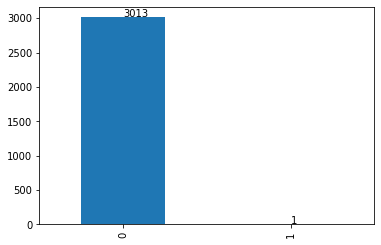

In [815]:
(timediff_noNA.request_cdiff).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.request_cdiff.value_counts()):
    plt.text(index, value+15, str(value))

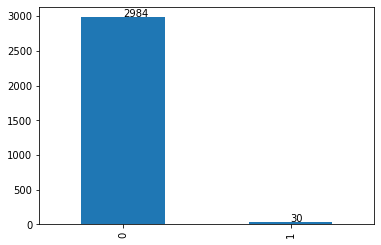

In [816]:
(timediff_noNA.request_mrsa).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.request_mrsa.value_counts()):
    plt.text(index, value+15, str(value))

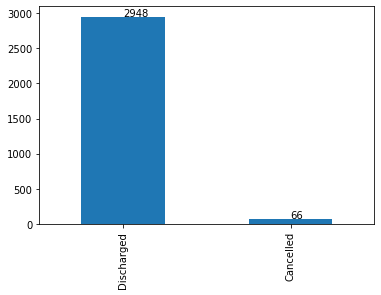

In [817]:
(timediff_noNA.callout_outcome).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.callout_outcome.value_counts()):
    plt.text(index, value+15, str(value))

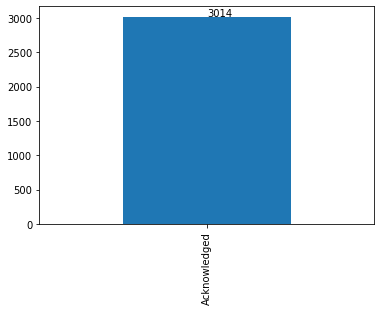

In [818]:
(timediff_noNA.acknowledge_status).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.acknowledge_status.value_counts()):
    plt.text(index, value+15, str(value))

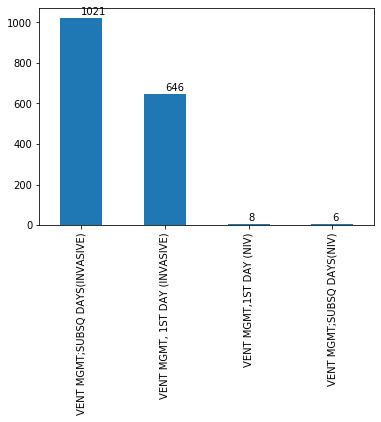

In [820]:
(timediff_noNA.description).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.description.value_counts()):
    plt.text(index, value+15, str(value))

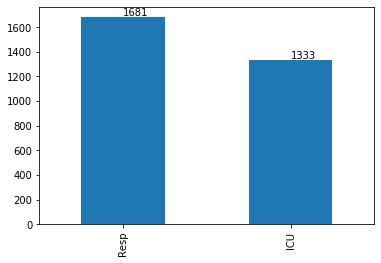

In [819]:
(timediff_noNA.costcenter).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.costcenter.value_counts()):
    plt.text(index, value+15, str(value))

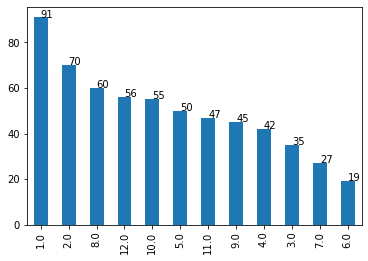

In [826]:
(timediff_noNA.deathmonth).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.deathmonth.value_counts()):
    plt.text(index, value, str(value))

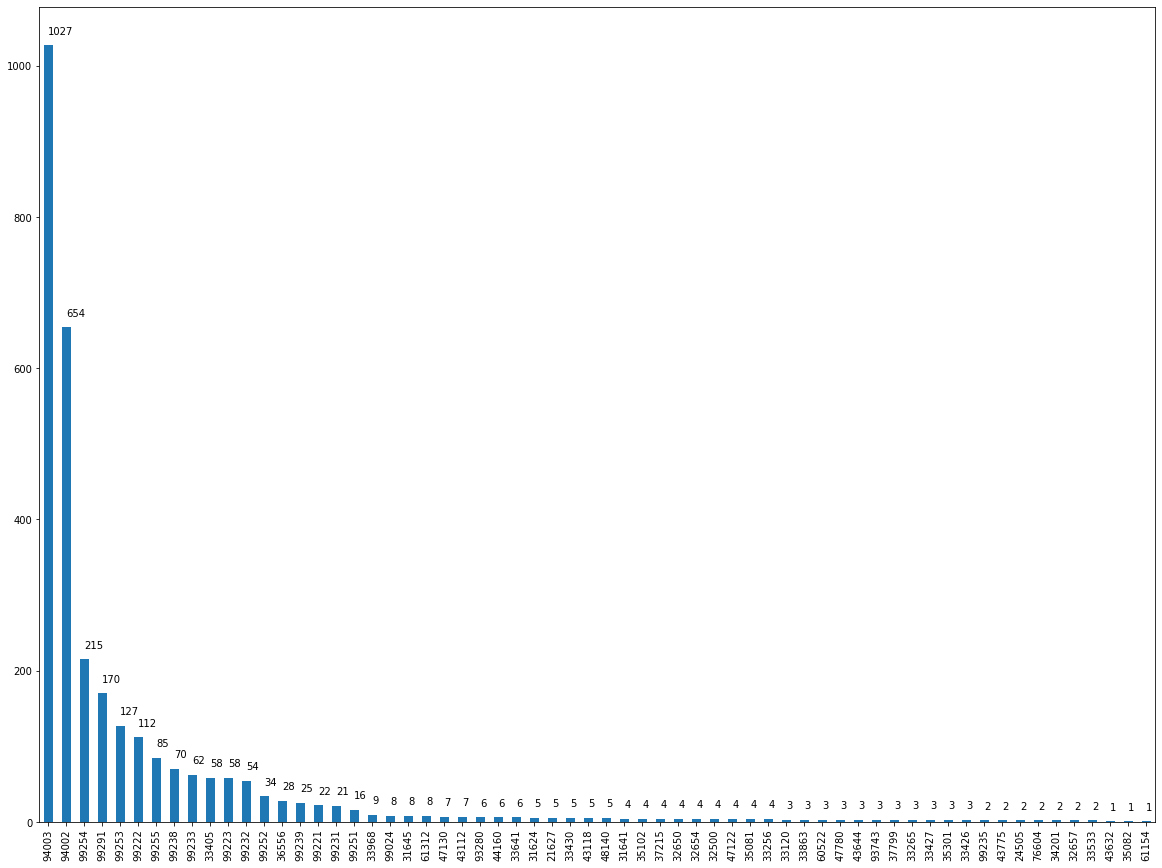

In [833]:
plt.figure(figsize=(20,15))
(timediff_noNA.cpt_cd).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.cpt_cd.value_counts()):
    plt.text(index, value+15, str(value))

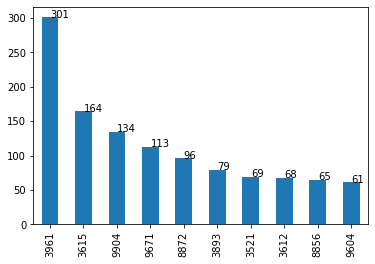

In [839]:
# Only showing top 10
(timediff_noNA.icd9_code).value_counts()[:10].plot(kind='bar')
for index, value in enumerate(timediff_noNA.icd9_code.value_counts()[:10]):
    plt.text(index, value, str(value))
    

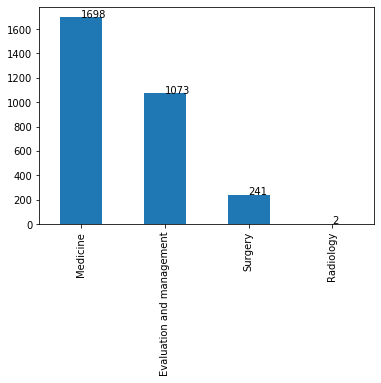

In [840]:
(timediff_noNA.sectionheader).value_counts().plot(kind='bar')
for index, value in enumerate(timediff_noNA.sectionheader.value_counts()):
    plt.text(index, value, str(value))

(array([1427., 1213.,  283.,   41.,   16.,   14.,   10.,    0.,    6.,
           4.]), array([8.200000e-03, 1.707710e+00, 3.407220e+00, 5.106730e+00,
        6.806240e+00, 8.505750e+00, 1.020526e+01, 1.190477e+01,
        1.360428e+01, 1.530379e+01, 1.700330e+01]), <a list of 10 Patch objects>)

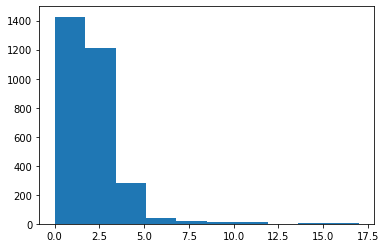

In [800]:
plt.hist(timediff_noNA.los)

(array([623., 504., 367., 249.,  83., 136., 130., 147., 318., 457.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

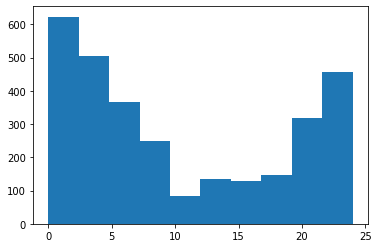

In [806]:
plt.hist(timediff_noNA.timediff_hours)

(array([367., 340., 439., 433., 246.,  81., 158., 259., 248., 443.]),
 array([ 0.  ,  2.39,  4.78,  7.17,  9.56, 11.95, 14.34, 16.73, 19.12,
        21.51, 23.9 ]),
 <a list of 10 Patch objects>)

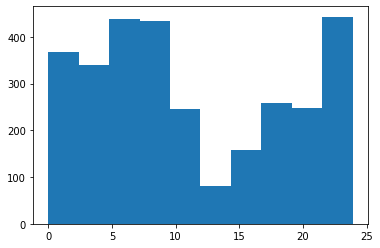

In [809]:
plt.hist(timediff_noNA.admit2disch_hours)

/Users/dereklee/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dereklee/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([179., 253., 202.,  83.,  23.,  19.,  12.,  10.,   0.,   2.]),
 array([ 0.1,  2.1,  4.1,  6.1,  8.1, 10.1, 12.1, 14.1, 16.1, 18.1, 20.1]),
 <a list of 10 Patch objects>)

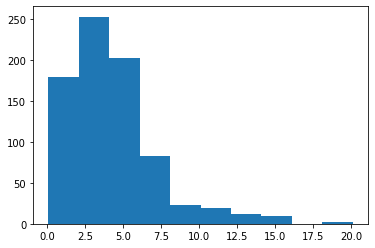

In [808]:
plt.hist(timediff_noNA.edreg2edout_hours)

(array([623., 504., 367., 249.,  83., 136., 130., 147., 318., 457.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

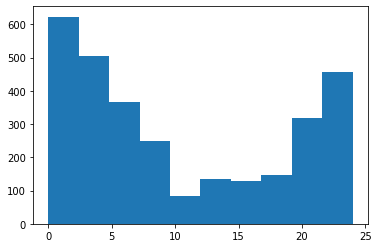

In [807]:
plt.hist(timediff_noNA.in2out_hours)

Text(0.5, 1.0, 'Distribution of ED registration time by Day of Month')

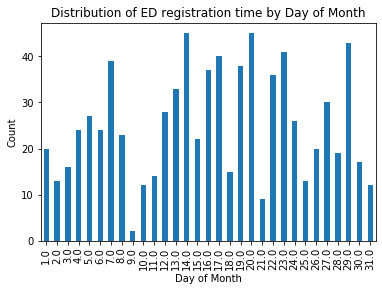

In [758]:
timediff_noNA["edregtime"].groupby(timediff_noNA["edregtime"].dt.day).count().plot(kind="bar")
# data["edregtime"].groupby(data["edregtime"].dt.day).count().plot.hist(bins=12, alpha= 0.5)
# data["edregtime"].groupby(data["edregtime"].dt.day).count().plot.hist()


plt.xlabel("Day of Month")
plt.ylabel("Count")
plt.title("Distribution of ED registration time by Day of Month")

Text(0.5, 1.0, 'Distribution of ED out time by Day of Month')

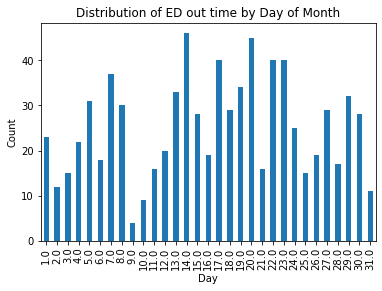

In [759]:
timediff_noNA["edouttime"].groupby(timediff_noNA["edouttime"].dt.day).count().plot(kind="bar")
# data["edouttime"].groupby(data["edouttime"].dt.day).count().plot.hist()
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of ED out time by Day of Month")

Text(0.5, 1.0, 'Distribution of admit time by Day of Month')

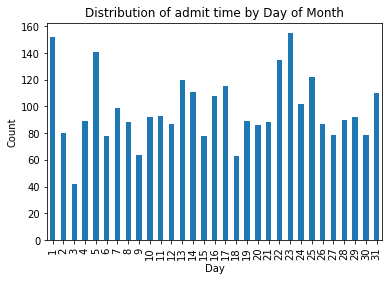

In [462]:
timediff_noNA["admittime"].groupby(timediff_noNA["admittime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of admit time by Day of Month")

Text(0.5, 1.0, 'Distribution of discharge time by Day of Month')

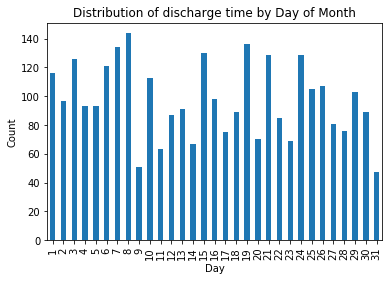

In [463]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.day).count().plot(kind="bar")
plt.xlabel("Day")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Day of Month")

We may want to create a new variable putting days into week in month (days 1-7, 8-14, 15-21, 22-31)

Text(0.5, 1.0, 'Distribution of discharge time by Month')

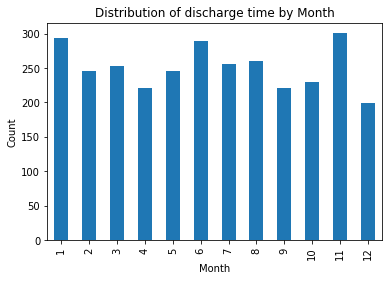

In [464]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.month).count().plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of discharge time by Month")

Text(0.5, 1.0, 'Distribution of discharge time by hour')

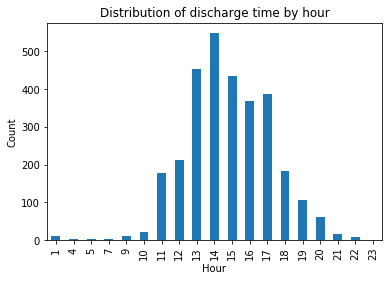

In [465]:
timediff_noNA["dischtime"].groupby(timediff_noNA["dischtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of discharge time by hour")

Text(0.5, 1.0, 'Distribution of death time by Month')

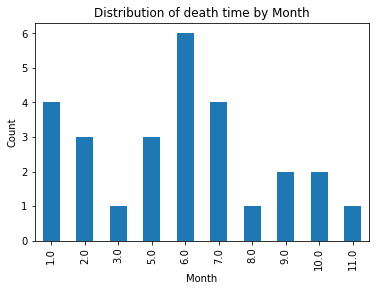

In [466]:
timediff_noNA["deathtime"].groupby(timediff_noNA["deathtime"].dt.month).count().plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of death time by Month")

Text(0.5, 1.0, 'Distribution of death time by Hour')

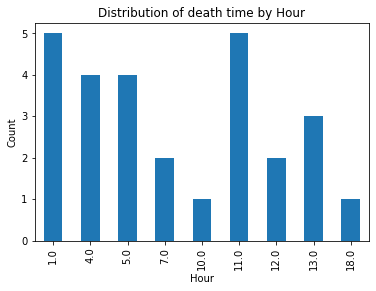

In [467]:
timediff_noNA["deathtime"].groupby(timediff_noNA["deathtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of death time by Hour")

Text(0.5, 1.0, 'Distribution of create time by hour')

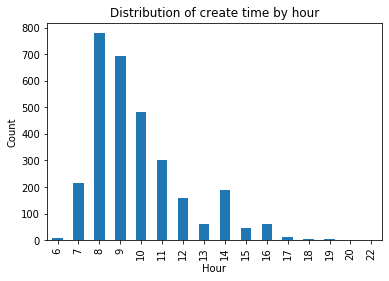

In [468]:
timediff_noNA["createtime"].groupby(timediff_noNA["createtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of create time by hour")

Text(0.5, 1.0, 'Distribution of update time by hour')

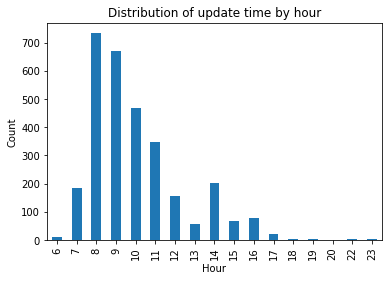

In [469]:
timediff_noNA["updatetime"].groupby(timediff_noNA["updatetime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of update time by hour")

Text(0.5, 1.0, 'Distribution of acknowledge time by hour')

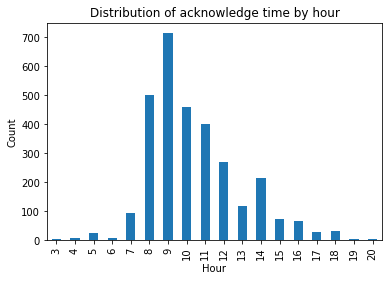

In [470]:
timediff_noNA["acknowledgetime"].groupby(timediff_noNA["acknowledgetime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of acknowledge time by hour")

Text(0.5, 1.0, 'Distribution of outcome time by hour')

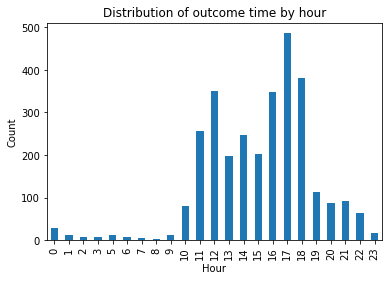

In [471]:
timediff_noNA["outcometime"].groupby(timediff_noNA["outcometime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of outcome time by hour")

Text(0.5, 1.0, 'Distribution of in time by hour')

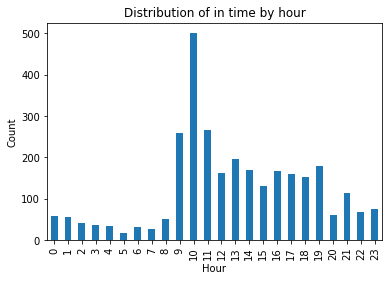

In [254]:
timediff_noNA["intime"].groupby(timediff_noNA["intime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of in time by hour")

Text(0.5, 1.0, 'Distribution of out time by hour')

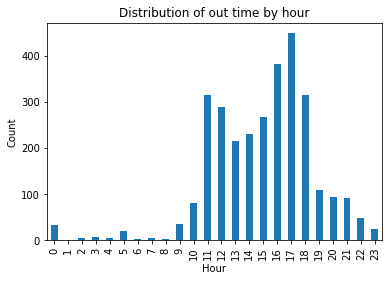

In [255]:
timediff_noNA["outtime"].groupby(timediff_noNA["outtime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of out time by hour")

Text(0.5, 1.0, 'Distribution of transfer time by hour')

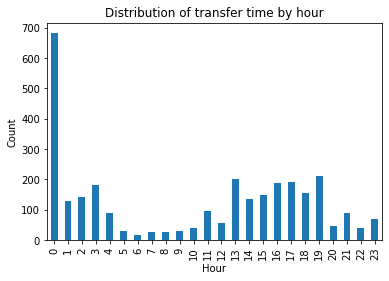

In [472]:
timediff_noNA["transfertime"].groupby(timediff_noNA["transfertime"].dt.hour).count().plot(kind="bar")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Distribution of transfer time by hour")

The above plots have shown us that there may be some trends with different time events.

When examining the days of the month that certain events happened, we see a lot of visits happen on the same day, meaning that the highest volume of `edregtime` and `edouttime` fall on the same days. In this dataset, they seem to fall overwhelmingly on the 7th, 13th, 14th, 17th, 20th, 22nd, and 29th of the month. The high turnover in emergency departments makes sense. On the other hand, `admittime` and `dischtime` don't necessarily fall on the same day. These are probably describing hospital stays over the course of several days.

Discharge times (`dischtime`) seem to most commonly occur during the afternoon hours from 1-5 pm. `deathtime` seems to be most common at 1 am and between 11 am and 12 pm. There may be some correlation there with how often rounds are made. 

`createtime` and `updatetime` describe call outs, or more specifically, the record of when patients were ready for discharge (called out), and the actual time of their discharge (or more generally, their outcome), as described by `outcometime`. `createtime`, `updatetime`, and `acknowledgetime` occur most frequently from 8 am - 10 am. `outcometime` occurs most frequently from 4 pm to 6 pm. This pattern warrants some further exploration to see truly how long each patient has to wait from when they are ready for discharge to when they are actually discharged.

The services table describes hospital services that patients were under during their hospital stay. `transfertime` describes the time when a transfer occured. The most common transfer time was overwhelmingly 12 am, followed by 1 pm, 3 am and 5 pm (equally common), and 7 pm.  





In [473]:
timediff_noNA.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

In [474]:
timediff_noNA['description'].unique() # only a few categories for the description so it's not really free text


array([None, 'VENT MGMT, 1ST DAY (INVASIVE)',
       'VENT MGMT;SUBSQ DAYS(INVASIVE)', 'VENT MGMT;SUBSQ DAYS(NIV)',
       'VENT MGMT,1ST DAY (NIV)'], dtype=object)

In [475]:
timediff_noNA['admission_location'].unique()

array(['TRANSFER FROM HOSP/EXTRAM', 'PHYS REFERRAL/NORMAL DELI',
       'EMERGENCY ROOM ADMIT', 'CLINIC REFERRAL/PREMATURE'], dtype=object)

In [476]:
timediff_noNA['admission_type'].unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT'], dtype=object)

In [477]:
timediff_noNA['discharge_location'].unique()

array(['REHAB/DISTINCT PART HOSP', 'HOME HEALTH CARE', 'HOME',
       'DISCH-TRAN TO PSYCH HOSP', 'SNF', 'LEFT AGAINST MEDICAL ADVI',
       'SHORT TERM HOSPITAL', 'DISC-TRAN CANCER/CHLDRN H', 'DEAD/EXPIRED',
       'LONG TERM CARE HOSPITAL'], dtype=object)

Now we want to make a correlation matrix of our data

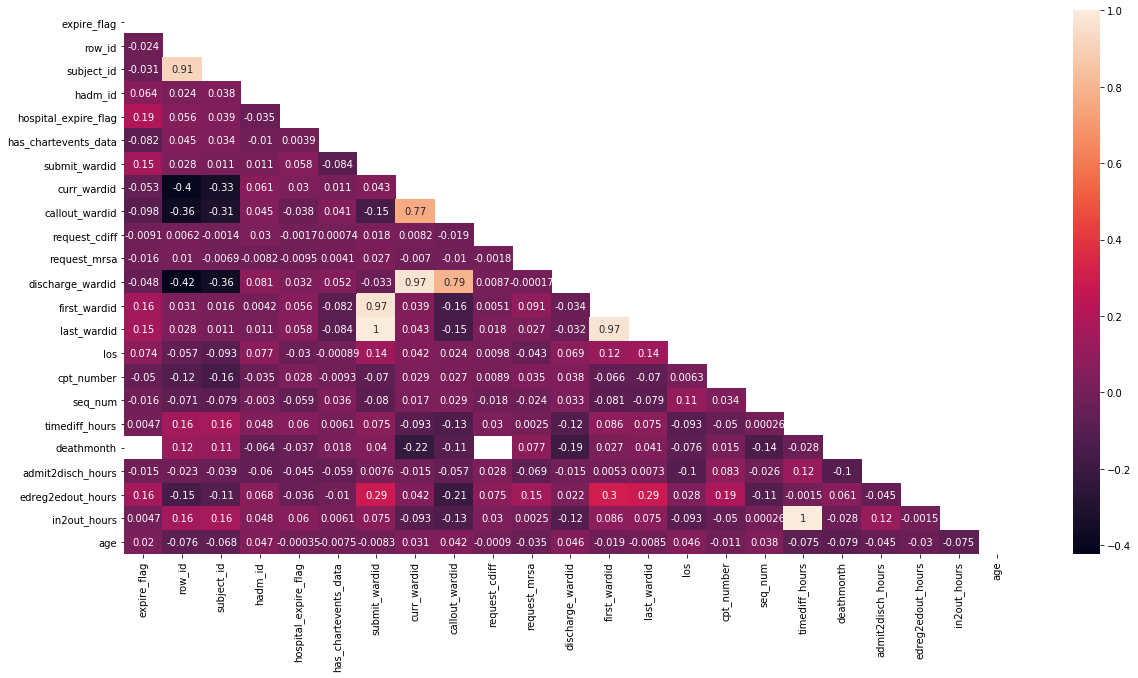

In [743]:
import seaborn as sns
a4_dims = (20, 10)
corrMatrix=timediff_noNA.corr()
mask_ut=np.triu(np.ones(corrMatrix.shape)).astype(np.bool)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(corrMatrix,mask=mask_ut,annot=True)
plt.show()

Evaluating the correlation matrix, `subject_id` and `row_id` seem to be pretty correlated. `callout_wardid` and `curr_wardid` makes sense they also would be highly correlated. Essentially all the ward_id's seem to be highly correlated so we'll have to deal with those: `first_wardid` and `last_wardid`, `callout_wardid` and `discharge_wardid`, `last_wardid` and `submit_wardid`, `discharge_wardid` and `curr_wardid`, `first_wardid` and `submit_wardid`. Everything else doesn't seem really correlated and negative correlations are all weak.

However, on second thought, these are mostly categorical variables and thus we can't realistically calculate the Pearson's Correlation Coefficient among them.

### ANOVA

In [479]:
timediff_noNA['timediff_hours'] = (timediff_noNA['outtime'].sub(data['intime']).dt.seconds/60/60).round(1)


/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


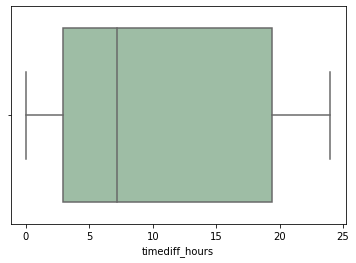

In [480]:
ax = sns.boxplot(timediff_noNA['timediff_hours'], data=timediff_noNA, color='#99c2a2')


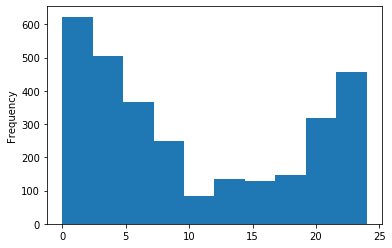

In [481]:
(timediff_noNA['timediff_hours']).plot.hist()

/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


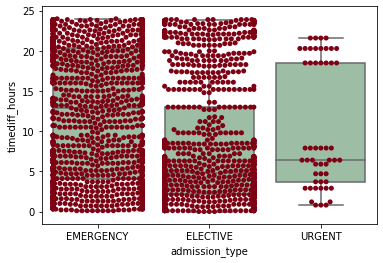

In [482]:
timediff_noNA['timediff_hours'] = (timediff_noNA['outtime'].sub(timediff_noNA['intime']).dt.seconds/60/60).round(1)

ax = sns.boxplot(x='admission_type', y=timediff_noNA['timediff_hours'], data=timediff_noNA, color='#99c2a2')
ax = sns.swarmplot(x="admission_type", y=timediff_noNA['timediff_hours'], data=timediff_noNA, color='#7d0013')
plt.show()



In [483]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


model = ols('timediff_hours ~ C(admission_type)', data=timediff_noNA).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(admission_type),13363.683932,2.0,104.961382,8.603683e-45
Residual,191680.270484,3011.0,NaN,NaN


In [484]:
import scikit_posthocs as sp
sp.posthoc_ttest(timediff_noNA, val_col='timediff_hours', group_col='admission_type', p_adjust='holm')

# significant difference between Emergency and Elective only

,EMERGENCY,ELECTIVE,URGENT
EMERGENCY,1.000000e+00,1.745545e-45,0.087832
ELECTIVE,1.745545e-45,1.000000e+00,0.081319
URGENT,8.783171e-02,8.131879e-02,1.000000


Based on these results, we may want to just look at Emergency and Urgent only since Emergency and Elective seem to show a significant difference at the 0.05 significance level. 




In [270]:
timediff_noNA[timediff_noNA['admission_type']=="EMERGENCY"].shape

(1565, 62)

In [271]:
timediff_noNA[timediff_noNA['admission_type']=="ELECTIVE"].shape

(1398, 62)

In [272]:
timediff_noNA[timediff_noNA['admission_type']=="URGENT"].shape

(51, 62)

## Refining dataset

In [524]:
timediff_ER_urgent = timediff_noNA[timediff_noNA['admission_type']!='ELECTIVE']

In [525]:
# reminder of columns with missing data

timediff_ER_urgent.columns[timediff_ER_urgent.isnull().any()]

Index(['dod', 'dod_hosp', 'dod_ssn', 'deathtime', 'language', 'marital_status',
       'edregtime', 'edouttime', 'submit_careunit', 'discharge_wardid',
       'cpt_suffix', 'description', 'prev_service', 'deathmonth',
       'edreg2edout_hours'],
      dtype='object')

In [526]:
timediff_ER_urgent.language.unique()

array([None, 'ENGL', 'SPAN', 'CANT', 'RUSS', 'ITAL', 'PORT', 'ETHI',
       'PTUN', 'CAPE', 'MAND'], dtype=object)

Do we want to eliminate those who died? Probably not.  
What to do about missing language and marital status? Categorize as unknown.  
Missing `submit_careunit`, `discharge_wardid` - what to do?  
Missing `cpt_suffix`,`description`, `prev_service`,`deathmonth`  = ignore  
`edreg2edout_hours` these are all patients who didn't go to ed (urgent care)

In [527]:
timediff_ER_urgent[timediff_ER_urgent.edreg2edout_hours.isna()==True].edouttime.unique()

array(['NaT'], dtype='datetime64[ns]')

In [528]:
# need to clean this up into fewer categories (lump some together)
# That way when dummy coding, if values are in list, code a new column as 1 else 0

sorted(timediff_ER_urgent.diagnosis.unique())


['ABDOMINAL ABSCESS',
 'ABDOMINAL AORTIC ANEURYSM',
 'ABDOMINAL AORTIC ANEURYSM;',
 'ABDOMINAL AORTIC ANURISM REPAIR',
 'ABDOMINAL INFECTION',
 'ABDOMINAL PAIN',
 'ACUTE CHOLECYSTITIS',
 'ACUTE CORONARY SYNDROME',
 'ACUTE CORONARY SYNDROME\\CATH',
 'ACUTE MYOCARDIAL INFARCTION',
 'ACUTE SUBDORAL HEMATOMA',
 'ACUTE SUBDURAL HEMATOMA',
 'AIRWAY OBSTRUCTION',
 'ALCOHOL WITHDRAWL;CARDIOMYOPATHY;VENTRICULAR TACHYCARDIA',
 'ALTERED MENTAL STATUS',
 'ALTERED MENTAL STATUS;TELEMETRY',
 'ANGINA;+ETT',
 'AORTIC DISSECTION',
 'AORTIC INSUFFICIENCY',
 'AORTIC STENISIS',
 'AORTIC STENOSIS',
 'AORTIC STENOSIS;CORONARY ARTERY DISEASE\\AORTIC ROOT REPLACEMENT REPAIR;? ASCENDING AORTIC REPLACEMENT',
 'AORTIC VALVE ENDOCARDITIS;AORTIC INSUFFICIENCY\\CATH',
 'ASCENDING THORASIC ANEURYSM',
 'ATRIAL TACHYCARDIA',
 'BLADDER PERFORATION',
 'BLADDER RUPTURE',
 'BLUNT TRAUMA',
 'BOWEL OBSTRUCTION',
 'BOWEL OBSTRUCTION;FAILURE TO THRIVE',
 'BOWEL PERFORATION',
 'BRADYCARDIA',
 'BRADYCARDIA;DIZZINESS',
 'BRAIN M

In [530]:
# may need to put this one line separate cell block
timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent.loc[:,'diagnosis']



timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['ABDOMINAL ABSCESS',
                                                                           'ABDOMINAL AORTIC ANEURYSM',
                                                                           'ABDOMINAL AORTIC ANEURYSM;',
                                                                           'ABDOMINAL AORTIC ANURISM REPAIR',
                                                                          'ABDOMINAL INFECTION',
                                                                           'ABDOMINAL PAIN',
                                                                           'ACUTE CHOLECYSTITIS',
                                                                           'BOWEL OBSTRUCTION',
                                                                           'BOWEL OBSTRUCTION;FAILURE TO THRIVE',
                                                                           'CHOLANGITIS','CHOLANGITIS ABSCESS',
                                                                            'CHOLECYSTITIS','ESOPHAGEAL FOREIGN BODY',
                                                                            'FOREIGN BODY IN ESOPHAGUS',
                                                                                      'FOREIGN BODY IN STOMACH',
                                                                                      'FOREIGN BODY INGESTION',
                                                                                      'GASTROINTESTINAL BLEED',
                                                                                      'GI BLEED',
                                                                                      'HEMATURIA;BLADDER BLEED',
                                                                                      'HEMOPERITONEUM',
                                                                                      'HEMOPTYSIS',
                                                                                      'ISCHEMIC BOWEL; HERNIA',
                                                                            'LIVER LACERATION',
                                                                            'LOWER GASTROINTESTINAL BLEED',
                                                                            'LOWER GI BLEED',
                                                                            'NEED GI SCOPE',
                                                                            'PANCREATIC ABCESS',
                                                                            'PANCREATITIS',
                                                                            'RECTAL BLEEDING',
                                                                            'RUPTURED DUODENAL ULCER',
                                                                            'SMALL BOWEL OBSTRUCTION',
                                                                            'SPLEENIC LACERATION',
                                                                            'UPPER GASTROINTESTINAL BLEED',
                                                                            'UPPER GI BLEED',
                                                                            'UPPER GI BLEED;TELEMETRY'],'GI')

timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['ACUTE CORONARY SYNDROME',
                                                                           'ACUTE CORONARY SYNDROME\\CATH',
                                                                           'ACUTE MYOCARDIAL INFARCTION',
                                                                           'ACUTE SUBDORAL HEMATOMA',
                                                                           'ACUTE SUBDURAL HEMATOMA',
                                                                          'ALCOHOL WITHDRAWL;CARDIOMYOPATHY;VENTRICULAR TACHYCARDIA',
                                                                           'ANGINA;+ETT','AORTIC DISSECTION',
                                                                           'AORTIC INSUFFICIENCY','AORTIC STENISIS',
                                                                           'AORTIC STENOSIS',
                                                                           'AORTIC STENOSIS;CORONARY ARTERY DISEASE\\AORTIC ROOT REPLACEMENT REPAIR;? ASCENDING AORTIC REPLACEMENT',
                                                                           'AORTIC VALVE ENDOCARDITIS;AORTIC INSUFFICIENCY\\CATH',
                                                                           'ASCENDING THORASIC ANEURYSM',
                                                                           'ATRIAL TACHYCARDIA','BRADYCARDIA',
                                                                           'BRADYCARDIA;DIZZINESS',
                                                                           'CAD,AORTIC VALVE DISEASE',
                                                                           'CARDIOMYOPATHY',
                                                                           'CAROTID STENOSIS',
                                                                           'CAROTID STENOSIS LEFT',
                                                                           'CAROTID STENOSIS\\CAROTID ANGIOGRAPHY',
                                                                           'CHEST PAIN',
                                                                           'CHEST PAIN/CATH',
                                                                           'CHEST PAIN;ABNORMAL ECHO;ADNORMAL EKG\\CARDIAC CATH',
                                                                           'CHEST PAIN;ANGINA PECTORIS\\CARDIAC CATH',
                                                                           'CHEST PAIN;NON-Q WAVE MI',
                                                                           'CHEST PAIN;RULE OUT CORONARY ARTERY DISEASE;ASPIRIN ALLERGY\\LEFT HEART CATHETERIZATION',
                                                                           'CHEST PAIN;UNSTABLE ANGINA',
                                                                           'CHEST PAIN\\ASPIRIN DESENSITIZATION;CATH',
                                                                           'CHEST PAIN\\CARDIAC CATH',
                                                                           'CHEST PAIN\\CARDIAC CATHETERIZATION',
                                                                           'CHEST PAIN\\CATH',
                                                                            'CLAUDICATION\\BILATERAL ANGIOGRAM WITH RUN-OFFS',
                                                                            'COMPLETE HEART BLOCK',
                                                                            'CONGESTIVE HEART FAILURE',
                                                                            'CONGESTIVE HEART FAILURE/MITRAL REGURGITATION',
                                                                            'CONGESTIVE HEART FAILURE;CORONARY ARTERY DISEASE',
                                                                            'CONGESTIVE HEART FAILURE;DYSPNEA\\CATH',
                                                                            'CONGESTIVE HEART FAILURE;TELEMETRY;CORONARY ARTERY DISEASE;DIABETES MELLITUS',
                                                                            'CONGESTIVE HEART FAILURE\\CATH',
                                                                            'CORONARY ARTERY DISEASE',
                                                                            'CORONARY ARTERY DISEASE/CATH',
                                                                            'CORONARY ARTERY DISEASE;+ETT\\CATH',
                                                                            'CORONARY ARTERY DISEASE;ANGINA\\CATH',
                                                                            'CORONARY ARTERY DISEASE;AORTIC STENOSIS',
                                                                            'CORONARY ARTERY DISEASE;CHEST PAIN',
                                                                            'CORONARY ARTERY DISEASE;DYSPNEA;COPD',
                                                                            'CORONARY ARTERY DISEASE;HYPERTENSION\\CATH',
                                                                            'CORONARY ARTERY DISEASE;PROGRESSIVE CHEST PAIN\\CATH',
                                                                            'CORONARY ARTERY DISEASE;UNSTABLE ANGINA',
                                                                            'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT',
                                                                            'CRITICAL AS , LEFT MAIN',
                                                                            'END ST ELEVATED MYOCARDIAL INFARCTION',
                                                                            'FOOT NUMBNESS;CLAUDICATION\\RIGHT LEG ANGIOGRAM',
                                                                            'HEART BLOCK,NON STE MI',
                                                                            'HYPOTENSION','ISCHEMIC FOOT',
                                                                            'LEFT ANTERIOR DESCENDING ARTERY PERFERATION',
                                                                            'LEFT ATRIAL TUMOR',
                                                                            'LEFT CELEBRAL STENOSIS/SDA',
                                                                            'MALFUCTION ICD','MITRAL REGURGITATION',
                                                                            'MITRAL REGURGITATION;CHF',
                                                                            'MITRAL VALVE DISEASE',
                                                                            'MYOCARDIAL INFARCTION\\CATH',
                                                                            'NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION',
                                                                            'NON-ST SEGMENT ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'PERF APPENDIX',
                                                                            'PERICARDIAL EFFUSION',
                                                                            'PERICARDIAL EFFUSION WITH TAMPONADE\\PERICARDIOCENTESIS',
                                                                            'PERICARDIAL EFFUSION\\PERICARDIAL TAP/SDA',
                                                                            'PNA/AFIB',
                                                                            'POLYMORPHIC VENTRICULAR TACHYCARDIA\\CARDIAC CATH',
                                                                            'PULSELESS LEFT FOOT',
                                                                            'RECURRENT VENTRICULAR TACHYCARDIA;STATUS POST IMPLANTABLE CARDIOVERTER DEFIBRILLATOR FIRING\\VENTRICULAR TACHYCARDIA ABLATION',
                                                                            'RUPTURED AORTIC PLAQUE',
                                                                            'S/P ARREST',
                                                                            'S/P CARDIAC ARREST',
                                                                            'S/P VFIB ARREST',
                                                                            'SDH/SAH',
                                                                            'SPONTANEOUS SAH',
                                                                            'ST ELEVATED MYOCARDIAL INFARCTION',
                                                                            'ST ELEVATED MYOCARDIAL INFARCTION\\CARDIAC CATHETERIZATION',
                                                                            'ST ELEVATION MI\\CATH',
                                                                            'ST ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'ST SEGMENT MYOCARDIAL INFARCTION\\CATH',
                                                                            'ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\\CATH',
                                                                            'STEMI',
                                                                            'STEMI\\CARDIAC CATH',
                                                                            'STEMYOCARDIAL INFARCTION',
                                                                            'STROKE/TIA',
                                                                            'SUBARACHNOID HEMATOMA',
                                                                            'SUBARACHNOID HEMORRHAGE',
                                                                            'SUBARACHNOID HEMORRHAGE;SDH;TELEMETRY',
                                                                            'SUBARRACHNOID HEMMORAGE',
                                                                            'SUBDURAL',
                                                                            'SUBDURAL HEMATOMA',
                                                                            'SUBDURAL HEMATOMA;TELEMETRY',
                                                                            'SUBDURAL HEMORRHAGE',
                                                                            'SUBURAL HEMATOMA;TELEMETRY',
                                                                            'SYMPTOMATIC BRADYCARDIA',
                                                                            'SYNCOPE;TELEMETRY',
                                                                            'THORACIC AORTIC ANEURYSM',
                                                                            'TRANSIENT ISCHEMIC ATTACK',
                                                                            'UNSTABLE ANGINA',
                                                                            'VENTRICULAR SEPTAL D EFFECT'],'CARDIOVASCULAR')

timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['ALTERED MENTAL STATUS',
                                                                           'ALTERED MENTAL STATUS;TELEMETRY',
                                                                           'BRAIN MASS',
                                                                           'BRAIN TUMOR',
                                                                            'EPIDURAL BLEED',
                                                                            'HYDROCEPHALUS','ICH',
                                                                            'INTRACEREBRAL HEMORRHAGE',
                                                                            'INTRACRANIAL BLEED',
                                                                            'INTRACRANIAL HEMORRHAGE',
                                                                            'INTRACRANIAL HEMORRHAGE;TELEMETRY',
                                                                            'INTRACRANIAL MASS',
                                                                            'INTRAPARENCHYMAL BLEED;TELEMETRY',
                                                                            'INTRAPARENCHYMAL HEMORRHAGE;TELEMETRY',
                                                                            'SEIZURE',
                                                                            'SEIZURE-HYDROCEPHALUS',
                                                                            'SEIZURE;SUBDURAL HEMORRHAGE',
                                                                            'SPIANAL METASTASES',
                                                                            'TRAUMA-HEAD INJURY',
                                                                            'TRAUMATIC SUBARACHNOID HEMORRHAGE'],'NEUROLOGICAL')


timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['AIRWAY OBSTRUCTION',
                                                                                      'HEMOTHORAX',
                                                                                      'HYPOXIA',
                                                                                      'MEDIASTINAL AIR',
                                                                                      'PNEUMONIA',
                                                                                      'PULMONARY EDEMA',
                                                                                      'PULMONARY EMBOLIS',
                                                                                      'RUPTURED DIAPHRAM',
                                                                                      'TRACHEOBRONCHEAL MALACIA'],'RESPIRATORY')


timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['BLUNT TRAUMA',
                                                                           'BOWEL PERFORATION',
                                                                            'CEREBRAL EDEMA',
                                                                           'CEREBROVASCULAR ACCIDENT',
                                                                           'CHEST STAB WOUNDS',
                                                                            'GUN SHOT WOUND',
                                                                            'GUN SHOT WOUND TO HEAD',
                                                                            'HEAD BLEED',
                                                                            'HEAD INJURY',
                                                                            'HEAD MAS',
                                                                            'HEAD MASS',
                                                                            'HEAD TRAUM',
                                                                            'HEAD TRAUMA;ETOH',
                                                                            'MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES',
                                                                            'MOTOR VEHICLE ACCIDENT\\INJURIES',
                                                                            'MULTIPLE STAB WOUNDS',
                                                                            'MULTIPLE TRAUMA',
                                                                            'NECK HEMATOMA',
                                                                            'ETOH INTOXICATION',
                                                                            'ETOH INTOXICATION;INTUBATED',
                                                                            'ETOH WITHDRAWAL',
                                                                            'POLYSUBSTANCE OVERDOSE',
                                                                            'S/P FALL',
                                                                            'S/P FALL; SPINE FX',
                                                                            'S/P FALL;FACIAL FRACTURE',
                                                                            'S/P GUN SHOT WOUND',
                                                                            'S/P MOTOR VEHICLE ACCIDEMT',
                                                                            'S/P MOTOR VEHICLE ACCIDENT',
                                                                            'S/P PEDESTRIAN STRUCK:INTRACRANIAL HEMORRHAGE',
                                                                            'S/P STAB WOUND',
                                                                            'S/P STAB WOUNDS',
                                                                            'STAB',
                                                                            'STAB WOUND',
                                                                            'STAB WOUND TO CHEST',
                                                                            'STAB WOUND TO NECK',
                                                                            'STAB WOUND TO THROAT',
                                                                            'STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES'],'GENERAL TRAUMA')

timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['CELLULITIS',
                                                                                     'INFECTED RIGHT FOOT',
                                                                                     'SEPSIS',
                                                                                    'SEPSIS/CELLULITIS'],'INFECTIONS')


timediff_ER_urgent['diagnosis_categories'] = timediff_ER_urgent['diagnosis_categories'].replace(['BLADDER RUPTURE',
                                                                                      'BLADDER PERFORATION',
                                                                                      'END STAGE LIVER DISEASE',
                                                                                      'FEBRILE;HYPOTENSIVE',
                                                                                      'FEVER',
                                                                                      'HEADACHE',
                                                                                      'OVERDOSE;TELEMETRY',
                                                                                      'PELVIC FRACTURE',
                                                                                      'PRESYNCOPE',
                                                                                      'TONSILLECTOMY BLEED',
                                                                                      'WEAKNESS'],'OTHER_DIAGNOSIS')



/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [531]:
timediff_ER_urgent.diagnosis_categories.unique()

array(['INFECTIONS', 'CARDIOVASCULAR', 'GENERAL TRAUMA', 'NEUROLOGICAL',
       'GI', 'OTHER_DIAGNOSIS', 'RESPIRATORY'], dtype=object)

In [532]:
timediff_ER_urgent['marital_status'] = timediff_ER_urgent['marital_status'].replace([None,'UNKNOWN (DEFAULT)'], 'UNKNOWN_MARITAL')
timediff_ER_urgent['ethnicity'] = timediff_ER_urgent['ethnicity'].replace(['UNKNOWN/NOT SPECIFIED',
                                                                           'PATIENT DECLINED TO ANSWER',
                                                                          'UNABLE TO OBTAIN'], 'UNKNOWN_ETHNICITY')
timediff_ER_urgent['ethnicity'] = timediff_ER_urgent['ethnicity'].replace(['ASIAN - CHINESE'], 'ASIAN')
timediff_ER_urgent['ethnicity'] = timediff_ER_urgent['ethnicity'].replace(['HISPANIC OR LATINO',
                                                                           'HISPANIC/LATINO - GUATEMALAN',
                                                                           'HISPANIC/LATINO - PUERTO RICAN',
                                                                           'HISPANIC/LATINO - DOMINICAN',
                                                                          'WHITE - BRAZILIAN'], 'HISPANIC_LATINO')
timediff_ER_urgent['ethnicity'] = timediff_ER_urgent['ethnicity'].replace(['BLACK/AFRICAN AMERICAN',
                                                                          'BLACK/AFRICAN',
                                                                           'BLACK/CAPE VERDEAN'], 'BLACK')

timediff_ER_urgent['ethnicity'] = timediff_ER_urgent['ethnicity'].replace(['MULTI RACE ETHNICITY'],'MIXED_ETHNICITY')
timediff_ER_urgent['ethnicity'] = timediff_ER_urgent['ethnicity'].replace(['OTHER'],'OTHER_ETHNICITY')

timediff_ER_urgent['language'] = timediff_ER_urgent['language'].replace([None],'UNKNOWN')

timediff_ER_urgent['description'] = timediff_ER_urgent['description'].replace([None],'NOT APPLICABLE')




/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/dereklee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [558]:
timediff_ER_urgent.callout_status.unique()

array(['Inactive'], dtype=object)

In [492]:
timediff_ER_urgent.columns

Index(['gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id',
       'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'submit_wardid', 'submit_careunit',
       'curr_wardid', 'curr_careunit', 'callout_wardid', 'callout_service',
       'request_cdiff', 'request_mrsa', 'callout_status', 'callout_outcome',
       'discharge_wardid', 'acknowledge_status', 'createtime', 'updatetime',
       'acknowledgetime', 'outcometime', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'costcenter',
       'cpt_cd', 'cpt_number', 'cpt_suffix', 'sectionheader',
       'subsectionheader', 'description', 'transfertime', 'prev_service',
       'curr_service', 'seq_num', 'icd9_code', 

In [559]:
# remaining columns:

dummies_cols = ['gender','deathmonth','admission_type','admission_location','discharge_location','insurance',
                                                                                 'language',
                                                                                 'religion',
                                                                                 'marital_status',
                                                                                 'ethnicity',
                                                                                 'submit_careunit',
                                                                                 'curr_wardid',
                                                                                 'curr_careunit',
                                                                                 'callout_wardid',
                                                                                 'callout_service',
                                                                                 'callout_outcome',
                                                                                 'callout_status',
                                                                                 'discharge_wardid',
                                                                                 'acknowledge_status',
                                                                                 'first_careunit',
                                                                                 'last_careunit',
                                                                                 'first_wardid',
                                                                                 'last_wardid',
                                                                                 'costcenter',
                                                                                 'cpt_cd',
                                                                                 'cpt_number',
                                                                                 'cpt_suffix',
                                                                                 'sectionheader',
                                                                                 'subsectionheader',
                                                                                 'description',
                                                                                 'prev_service',
                                                                                 'curr_service',
                                                                                 'seq_num',
                                                                                 'icd9_code',
                                                                                 'diagnosis_categories']

df_with_dummies = pd.get_dummies(timediff_ER_urgent, prefix=dummies_cols, columns=dummies_cols)





In [560]:
sorted(df_with_dummies.columns)

['acknowledge_status_Acknowledged',
 'acknowledgetime',
 'admission_location_CLINIC REFERRAL/PREMATURE',
 'admission_location_EMERGENCY ROOM ADMIT',
 'admission_location_PHYS REFERRAL/NORMAL DELI',
 'admission_location_TRANSFER FROM HOSP/EXTRAM',
 'admission_type_EMERGENCY',
 'admission_type_URGENT',
 'admit2disch_hours',
 'admittime',
 'age',
 'callout_outcome_Cancelled',
 'callout_outcome_Discharged',
 'callout_service_CCU',
 'callout_service_CMED',
 'callout_service_CSURG',
 'callout_service_ENT',
 'callout_service_GU',
 'callout_service_MED',
 'callout_service_NMED',
 'callout_service_NSURG',
 'callout_service_SURG',
 'callout_service_TRAUM',
 'callout_service_TSURG',
 'callout_service_VSURG',
 'callout_status_Inactive',
 'callout_wardid_1',
 'callout_wardid_17',
 'callout_wardid_2',
 'callout_wardid_24',
 'callout_wardid_29',
 'callout_wardid_3',
 'callout_wardid_31',
 'callout_wardid_36',
 'callout_wardid_39',
 'callout_wardid_4',
 'callout_wardid_40',
 'callout_wardid_44',
 'cal

In [517]:
len(df_with_dummies.columns)

585

In [518]:
df_with_dummies.acknowledgetime.dtype

dtype('<M8[ns]')

In [519]:
df_with_dummies.head()

,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,submit_wardid,request_cdiff,request_mrsa,callout_status,createtime,updatetime,acknowledgetime,outcometime,intime,outtime,los,description,transfertime,timediff,timediff_hours,admit2disch_hours,edreg2edout_hours,in2out_hours,age,gender_F,gender_M,deathmonth_1.0,deathmonth_2.0,deathmonth_3.0,deathmonth_4.0,deathmonth_5.0,deathmonth_6.0,deathmonth_7.0,deathmonth_8.0,deathmonth_9.0,deathmonth_10.0,deathmonth_11.0,deathmonth_12.0,admission_type_EMERGENCY,admission_type_URGENT,admission_location_CLINIC REFERRAL/PREMATURE,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,discharge_location_DEAD/EXPIRED,discharge_location_DISC-TRAN CANCER/CHLDRN H,discharge_location_DISCH-TRAN TO PSYCH HOSP,discharge_location_HOME,discharge_location_HOME HEALTH CARE,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SNF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,language_CANT,language_CAPE,language_ENGL,language_ETHI,language_ITAL,language_MAND,language_PORT,language_PTUN,language_RUSS,language_SPAN,language_UNKNOWN,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_EPISCOPALIAN,religion_GREEK ORTHODOX,religion_HINDU,religion_JEWISH,religion_MUSLIM,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN_MARITAL,marital_status_WIDOWED,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_HISPANIC_LATINO,ethnicity_MIXED_ETHNICITY,ethnicity_OTHER_ETHNICITY,ethnicity_UNKNOWN_ETHNICITY,ethnicity_WHITE,submit_careunit_CCU,submit_careunit_CSRU,submit_careunit_MICU,submit_careunit_SICU,submit_careunit_TSICU,curr_wardid_2,curr_wardid_3,curr_wardid_4,curr_wardid_7,curr_wardid_8,curr_wardid_12,curr_wardid_14,curr_wardid_17,curr_wardid_18,curr_wardid_23,curr_wardid_24,curr_wardid_29,curr_wardid_31,curr_wardid_33,curr_wardid_36,curr_wardid_40,curr_wardid_45,curr_wardid_49,curr_wardid_50,curr_wardid_52,curr_wardid_54,curr_wardid_55,curr_wardid_57,curr_careunit_CCU,curr_careunit_CSRU,curr_careunit_MICU,curr_careunit_SICU,curr_careunit_TSICU,callout_wardid_1,callout_wardid_2,callout_wardid_3,callout_wardid_4,callout_wardid_7,callout_wardid_8,callout_wardid_17,callout_wardid_24,callout_wardid_29,callout_wardid_31,callout_wardid_36,callout_wardid_39,callout_wardid_40,callout_wardid_44,callout_wardid_54,callout_wardid_55,callout_service_CCU,callout_service_CMED,callout_service_CSURG,callout_service_ENT,callout_service_GU,callout_service_MED,callout_service_NMED,callout_service_NSURG,callout_service_SURG,callout_service_TRAUM,callout_service_TSURG,callout_service_VSURG,callout_outcome_Cancelled,callout_outcome_Discharged,discharge_wardid_0.0,discharge_wardid_2.0,discharge_wardid_3.0,discharge_wardid_4.0,discharge_wardid_8.0,discharge_wardid_17.0,discharge_wardid_18.0,discharge_wardid_24.0,discharge_wardid_29.0,discharge_wardid_31.0,discharge_wardid_36.0,discharge_wardid_40.0,discharge_wardid_45.0,discharge_wardid_49.0,discharge_wardid_54.0,discharge_wardid_55.0,acknowledge_status_Acknowledged,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,last_careunit_CCU,last_careunit_CSRU,last_careunit_MICU,last_careunit_SICU,last_careunit_TSICU,first_wardid_7,first_wardid_12,first_wardid_14,first_wardid_15,first_wardid_23,first_wardid_33,first_wardid_50,first_wardid_52,first_wardid_57,last_wardid_7,last_wardid_12,last_wardid_14,last_wardid_15,last_wardid_23,last_wardid_33,last_wardid_50,last_wardid_52,last_wardid_57,costcenter_ICU,costcenter_Resp,cpt_cd_24505,cpt_cd_31641,cp

In [562]:
# drop unnecessary columns in final dataset:

final_df = df_with_dummies.drop(columns=['admittime','createtime','diagnosis','dischtime', 'deathtime', 'acknowledgetime',
                                         'dob','dod','dod_hosp',
                                        'dod_ssn','edouttime','edregtime','intime','outcometime','outtime',
                                        'row_id','transfertime','updatetime','timediff'])






In [563]:
sorted(final_df.columns)

['acknowledge_status_Acknowledged',
 'admission_location_CLINIC REFERRAL/PREMATURE',
 'admission_location_EMERGENCY ROOM ADMIT',
 'admission_location_PHYS REFERRAL/NORMAL DELI',
 'admission_location_TRANSFER FROM HOSP/EXTRAM',
 'admission_type_EMERGENCY',
 'admission_type_URGENT',
 'admit2disch_hours',
 'age',
 'callout_outcome_Cancelled',
 'callout_outcome_Discharged',
 'callout_service_CCU',
 'callout_service_CMED',
 'callout_service_CSURG',
 'callout_service_ENT',
 'callout_service_GU',
 'callout_service_MED',
 'callout_service_NMED',
 'callout_service_NSURG',
 'callout_service_SURG',
 'callout_service_TRAUM',
 'callout_service_TSURG',
 'callout_service_VSURG',
 'callout_status_Inactive',
 'callout_wardid_1',
 'callout_wardid_17',
 'callout_wardid_2',
 'callout_wardid_24',
 'callout_wardid_29',
 'callout_wardid_3',
 'callout_wardid_31',
 'callout_wardid_36',
 'callout_wardid_39',
 'callout_wardid_4',
 'callout_wardid_40',
 'callout_wardid_44',
 'callout_wardid_54',
 'callout_wardid_

## Final Dataset:

In [573]:
# using the hours column may help us avoid converting to cyclical time features esp if we don't care about cyclical

y = final_df.timediff_hours

X = final_df.loc[:, final_df.columns != 'timediff_hours']


# Random Forest

In [574]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [575]:
X_train.head()

,expire_flag,subject_id,hadm_id,hospital_expire_flag,has_chartevents_data,submit_wardid,request_cdiff,request_mrsa,los,admit2disch_hours,edreg2edout_hours,in2out_hours,age,gender_F,gender_M,deathmonth_1.0,deathmonth_2.0,deathmonth_3.0,deathmonth_4.0,deathmonth_5.0,deathmonth_6.0,deathmonth_7.0,deathmonth_8.0,deathmonth_9.0,deathmonth_10.0,deathmonth_11.0,deathmonth_12.0,admission_type_EMERGENCY,admission_type_URGENT,admission_location_CLINIC REFERRAL/PREMATURE,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,discharge_location_DEAD/EXPIRED,discharge_location_DISC-TRAN CANCER/CHLDRN H,discharge_location_DISCH-TRAN TO PSYCH HOSP,discharge_location_HOME,discharge_location_HOME HEALTH CARE,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SNF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,language_CANT,language_CAPE,language_ENGL,language_ETHI,language_ITAL,language_MAND,language_PORT,language_PTUN,language_RUSS,language_SPAN,language_UNKNOWN,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_EPISCOPALIAN,religion_GREEK ORTHODOX,religion_HINDU,religion_JEWISH,religion_MUSLIM,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN_MARITAL,marital_status_WIDOWED,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_HISPANIC_LATINO,ethnicity_MIXED_ETHNICITY,ethnicity_OTHER_ETHNICITY,ethnicity_UNKNOWN_ETHNICITY,ethnicity_WHITE,submit_careunit_CCU,submit_careunit_CSRU,submit_careunit_MICU,submit_careunit_SICU,submit_careunit_TSICU,curr_wardid_2,curr_wardid_3,curr_wardid_4,curr_wardid_7,curr_wardid_8,curr_wardid_12,curr_wardid_14,curr_wardid_17,curr_wardid_18,curr_wardid_23,curr_wardid_24,curr_wardid_29,curr_wardid_31,curr_wardid_33,curr_wardid_36,curr_wardid_40,curr_wardid_45,curr_wardid_49,curr_wardid_50,curr_wardid_52,curr_wardid_54,curr_wardid_55,curr_wardid_57,curr_careunit_CCU,curr_careunit_CSRU,curr_careunit_MICU,curr_careunit_SICU,curr_careunit_TSICU,callout_wardid_1,callout_wardid_2,callout_wardid_3,callout_wardid_4,callout_wardid_7,callout_wardid_8,callout_wardid_17,callout_wardid_24,callout_wardid_29,callout_wardid_31,callout_wardid_36,callout_wardid_39,callout_wardid_40,callout_wardid_44,callout_wardid_54,callout_wardid_55,callout_service_CCU,callout_service_CMED,callout_service_CSURG,callout_service_ENT,callout_service_GU,callout_service_MED,callout_service_NMED,callout_service_NSURG,callout_service_SURG,callout_service_TRAUM,callout_service_TSURG,callout_service_VSURG,callout_outcome_Cancelled,callout_outcome_Discharged,callout_status_Inactive,discharge_wardid_0.0,discharge_wardid_2.0,discharge_wardid_3.0,discharge_wardid_4.0,discharge_wardid_8.0,discharge_wardid_17.0,discharge_wardid_18.0,discharge_wardid_24.0,discharge_wardid_29.0,discharge_wardid_31.0,discharge_wardid_36.0,discharge_wardid_40.0,discharge_wardid_45.0,discharge_wardid_49.0,discharge_wardid_54.0,discharge_wardid_55.0,acknowledge_status_Acknowledged,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,last_careunit_CCU,last_careunit_CSRU,last_careunit_MICU,last_careunit_SICU,last_careunit_TSICU,first_wardid_7,first_wardid_12,first_wardid_14,first_wardid_15,first_wardid_23,first_wardid_33,first_wardid_50,first_wardid_52,first_wardid_57,last_wardid_7,last_wardid_12,last_wardid_14,last_wardid_15,last_wardid_23,last_wardid_33,last_wardid_50,last_wardid_52,last_wardid_57,costcenter_ICU,costcenter_Resp,cpt_cd_24505,cpt_cd_31641,cpt_cd_31645,cpt_cd_32654,cpt_cd_33120,cpt_cd_33968,cpt_cd_34201,cpt_cd_35082,cpt_cd_36556,cpt_cd_37215,cpt_cd_48140,cpt_cd_61312,cpt_cd_93280,cpt_cd_94002,cpt_cd_94003,cpt_cd_99024,cpt_cd_99221,cpt_

In [576]:
for d in X_train:
    print(d,": " ,X_train[d].dtype)

expire_flag :  int64
subject_id :  int64
hadm_id :  int64
hospital_expire_flag :  int64
has_chartevents_data :  int64
submit_wardid :  int64
request_cdiff :  int64
request_mrsa :  int64
los :  float64
admit2disch_hours :  float64
edreg2edout_hours :  float64
in2out_hours :  float64
age :  int64
gender_F :  uint8
gender_M :  uint8
deathmonth_1.0 :  uint8
deathmonth_2.0 :  uint8
deathmonth_3.0 :  uint8
deathmonth_4.0 :  uint8
deathmonth_5.0 :  uint8
deathmonth_6.0 :  uint8
deathmonth_7.0 :  uint8
deathmonth_8.0 :  uint8
deathmonth_9.0 :  uint8
deathmonth_10.0 :  uint8
deathmonth_11.0 :  uint8
deathmonth_12.0 :  uint8
admission_type_EMERGENCY :  uint8
admission_type_URGENT :  uint8
admission_location_CLINIC REFERRAL/PREMATURE :  uint8
admission_location_EMERGENCY ROOM ADMIT :  uint8
admission_location_PHYS REFERRAL/NORMAL DELI :  uint8
admission_location_TRANSFER FROM HOSP/EXTRAM :  uint8
discharge_location_DEAD/EXPIRED :  uint8
discharge_location_DISC-TRAN CANCER/CHLDRN H :  uint8
discha

In [583]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [614]:
from sklearn.ensemble import RandomForestRegressor

ImportError: cannot import name '_to_object_array'

In [590]:
import sklearn
sklearn.show_versions()


System:
    python: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46)  [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
executable: /Users/dereklee/anaconda3/bin/python
   machine: Darwin-18.7.0-x86_64-i386-64bit

Python dependencies:
       pip: 19.1.1
setuptools: 41.0.1
   sklearn: 0.22.1
     numpy: 1.18.5
     scipy: 1.4.1
    Cython: 0.29.7
    pandas: 0.25.3
matplotlib: 3.1.3
    joblib: 0.14.1

Built with OpenMP: True


In [587]:


# regressor = RandomForestRegressor(n_estimators=20, random_state=42) # n_estimators is no. of trees
# regressor.fit(X_train, y_train)
# y_pred = regressor.predict(X_test)

In [588]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


# You can play around with the number of trees and other parameters to see 
# if you can get better results



NameError: name 'y_pred' is not defined

Below code is different one that allows feature importance:  
Documentation seems to show DecisionTreeRegressor is an attribute of RandomForestRegressor:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [613]:
from sklearn.tree import DecisionTreeRegressor
# from matplotlib import pyplot
# # define dataset
# # X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# # define the model
# model = DecisionTreeRegressor()
# # fit the model
# model.fit(X_train, y_train)
# # get importance
# importance = model.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

ImportError: cannot import name '_to_object_array'

# Linear Regression

In [611]:
from sklearn.linear_model import LinearRegression

In [618]:
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(X,y)

AttributeError: 'LinearRegression' object has no attribute '_validate_data'

In [622]:
X

,expire_flag,subject_id,hadm_id,hospital_expire_flag,has_chartevents_data,submit_wardid,request_cdiff,request_mrsa,los,admit2disch_hours,edreg2edout_hours,in2out_hours,age,gender_F,gender_M,deathmonth_1.0,deathmonth_2.0,deathmonth_3.0,deathmonth_4.0,deathmonth_5.0,deathmonth_6.0,deathmonth_7.0,deathmonth_8.0,deathmonth_9.0,deathmonth_10.0,deathmonth_11.0,deathmonth_12.0,admission_type_EMERGENCY,admission_type_URGENT,admission_location_CLINIC REFERRAL/PREMATURE,admission_location_EMERGENCY ROOM ADMIT,admission_location_PHYS REFERRAL/NORMAL DELI,admission_location_TRANSFER FROM HOSP/EXTRAM,discharge_location_DEAD/EXPIRED,discharge_location_DISC-TRAN CANCER/CHLDRN H,discharge_location_DISCH-TRAN TO PSYCH HOSP,discharge_location_HOME,discharge_location_HOME HEALTH CARE,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SNF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,language_CANT,language_CAPE,language_ENGL,language_ETHI,language_ITAL,language_MAND,language_PORT,language_PTUN,language_RUSS,language_SPAN,language_UNKNOWN,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_EPISCOPALIAN,religion_GREEK ORTHODOX,religion_HINDU,religion_JEWISH,religion_MUSLIM,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN_MARITAL,marital_status_WIDOWED,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_HISPANIC_LATINO,ethnicity_MIXED_ETHNICITY,ethnicity_OTHER_ETHNICITY,ethnicity_UNKNOWN_ETHNICITY,ethnicity_WHITE,submit_careunit_CCU,submit_careunit_CSRU,submit_careunit_MICU,submit_careunit_SICU,submit_careunit_TSICU,curr_wardid_2,curr_wardid_3,curr_wardid_4,curr_wardid_7,curr_wardid_8,curr_wardid_12,curr_wardid_14,curr_wardid_17,curr_wardid_18,curr_wardid_23,curr_wardid_24,curr_wardid_29,curr_wardid_31,curr_wardid_33,curr_wardid_36,curr_wardid_40,curr_wardid_45,curr_wardid_49,curr_wardid_50,curr_wardid_52,curr_wardid_54,curr_wardid_55,curr_wardid_57,curr_careunit_CCU,curr_careunit_CSRU,curr_careunit_MICU,curr_careunit_SICU,curr_careunit_TSICU,callout_wardid_1,callout_wardid_2,callout_wardid_3,callout_wardid_4,callout_wardid_7,callout_wardid_8,callout_wardid_17,callout_wardid_24,callout_wardid_29,callout_wardid_31,callout_wardid_36,callout_wardid_39,callout_wardid_40,callout_wardid_44,callout_wardid_54,callout_wardid_55,callout_service_CCU,callout_service_CMED,callout_service_CSURG,callout_service_ENT,callout_service_GU,callout_service_MED,callout_service_NMED,callout_service_NSURG,callout_service_SURG,callout_service_TRAUM,callout_service_TSURG,callout_service_VSURG,callout_outcome_Cancelled,callout_outcome_Discharged,callout_status_Inactive,discharge_wardid_0.0,discharge_wardid_2.0,discharge_wardid_3.0,discharge_wardid_4.0,discharge_wardid_8.0,discharge_wardid_17.0,discharge_wardid_18.0,discharge_wardid_24.0,discharge_wardid_29.0,discharge_wardid_31.0,discharge_wardid_36.0,discharge_wardid_40.0,discharge_wardid_45.0,discharge_wardid_49.0,discharge_wardid_54.0,discharge_wardid_55.0,acknowledge_status_Acknowledged,first_careunit_CCU,first_careunit_CSRU,first_careunit_MICU,first_careunit_SICU,first_careunit_TSICU,last_careunit_CCU,last_careunit_CSRU,last_careunit_MICU,last_careunit_SICU,last_careunit_TSICU,first_wardid_7,first_wardid_12,first_wardid_14,first_wardid_15,first_wardid_23,first_wardid_33,first_wardid_50,first_wardid_52,first_wardid_57,last_wardid_7,last_wardid_12,last_wardid_14,last_wardid_15,last_wardid_23,last_wardid_33,last_wardid_50,last_wardid_52,last_wardid_57,costcenter_ICU,costcenter_Resp,cpt_cd_24505,cpt_cd_31641,cpt_cd_31645,cpt_cd_32654,cpt_cd_33120,cpt_cd_33968,cpt_cd_34201,cpt_cd_35082,cpt_cd_36556,cpt_cd_37215,cpt_cd_48140,cpt_cd_61312,cpt_cd_93280,cpt_cd_94002,cpt_cd_94003,cpt_cd_99024,cpt_cd_99221,cpt_

# MLP Regressor

In [655]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

[-3.03334939e-17 -2.74977831e-18 -1.82172815e-17  4.12466763e-17
 -8.88522143e-17 -9.48673526e-17 -8.18059060e-17 -2.91476504e-16
  0.00000000e+00  5.49955662e-17  0.00000000e+00 -5.08708996e-17
  5.49955662e-18  3.07975171e-16 -2.74977838e-16  1.27864692e-16
 -1.95234265e-16 -6.59946795e-17 -8.24933527e-17 -1.40926149e-17
  1.39551259e-16 -1.75985812e-16  1.03116693e-16  1.41613586e-16
  1.97984038e-16 -2.74977831e-17  1.92484492e-16  1.83719567e-16
 -1.83719567e-16  1.75985812e-16 -4.23465863e-16 -1.36114026e-16
  3.94593210e-16  4.12466763e-17  0.00000000e+00 -1.31645636e-16
 -5.08708996e-17 -2.74977831e-18 -1.15490692e-16 -1.34739146e-16
  2.39230718e-16  1.63611812e-16  3.57471197e-16  2.77727624e-16
  9.89920192e-17  2.41980505e-16  1.11366026e-16 -5.91202369e-16
 -1.01741799e-16 -1.07241359e-16  0.00000000e+00 -2.10358052e-16
  3.52659071e-16  8.52431326e-17 -4.94960096e-17 -1.75985812e-16
 -3.38222744e-16  1.31989359e-16 -5.36206796e-17  2.47480051e-16
 -4.31715197e-16 -1.92484

In [656]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 568)               1137      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 569       
Total params: 1,706
Trainable params: 569
Non-trainable params: 1,137
_________________________________________________________________


In [657]:
linear_model.predict(y_train)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [658]:
linear_model.layers[1].kernel

<tf.Variable 'dense_15/kernel:0' shape=(568, 1) dtype=float32, numpy=
array([[ 4.83788252e-02],
       [-3.68921235e-02],
       [-6.08890802e-02],
       [ 8.10917020e-02],
       [ 4.76892740e-02],
       [ 9.20909047e-02],
       [ 8.14460665e-02],
       [-2.40577012e-03],
       [ 6.05973452e-02],
       [-3.18115950e-02],
       [ 2.56268233e-02],
       [ 6.30681068e-02],
       [-4.64846231e-02],
       [-1.01734325e-01],
       [-1.13242865e-02],
       [ 8.73125345e-02],
       [-2.12284923e-03],
       [-7.83380866e-03],
       [-7.00418651e-03],
       [-2.83387899e-02],
       [-5.05562201e-02],
       [-6.51547462e-02],
       [-1.03402287e-02],
       [-2.42143869e-02],
       [-8.98897126e-02],
       [-9.08481628e-02],
       [-2.07166895e-02],
       [ 7.47186244e-02],
       [ 4.87094969e-02],
       [-9.37649384e-02],
       [ 6.54726475e-03],
       [-1.01913422e-01],
       [-6.76371306e-02],
       [-4.25395258e-02],
       [ 7.72696584e-02],
       [-7.07480237e

In [660]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [662]:
%%time
history = linear_model.fit(
    X_train, y_train, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 4.35 s, sys: 694 ms, total: 5.04 s
Wall time: 3.47 s


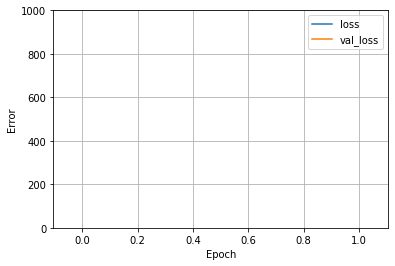

In [682]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# MLP DNN

In [676]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [677]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 568)               1137      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                36416     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 41,778
Trainable params: 40,641
Non-trainable params: 1,137
_________________________________________________________________


In [678]:
%%time
history = dnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.61 s, sys: 1.5 s, total: 8.11 s
Wall time: 4.38 s


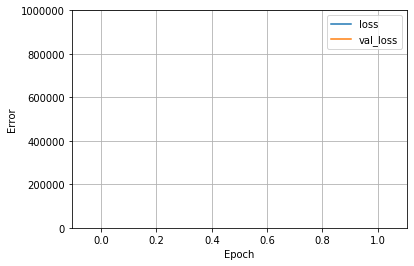

In [679]:
plot_loss(history)


In [680]:
test_results = {}

test_results['dnn_model'] = dnn_model.evaluate(
    X_test,
    y_test, verbose=0)

In [681]:
test_results['dnn_model']

nan